In [1]:
#Important packages to install uncomment if you dont have it
#!pip install kneed
#!pip install yellowbrick
#!pip install threadpoolctl==3.1.0
#!git clone https://github.com/parrt/dtreeviz.git

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from  sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

In [3]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
random_seed= 42

In [4]:
edges = './dataset/UofT_edges.csv'
nodes = './dataset/UofT_nodes.csv'
occ_risk = './dataset/UofT_occupation_risk.csv'
risk_sheet = './dataset/risk_sheet.xlsx'


In [4]:
#Config parameters 
nK = 20  # to check silhouette score upto nk=20
latent_dim = 10#4 # Change to latent dimension required.
version = 9 # specify a version to save results of models

In [6]:
edge_df = pd.read_csv(edges)
nodes_df = pd.read_csv(nodes)
occrisk_df = pd.read_csv(occ_risk)


In [7]:
risk_df = pd.read_excel(risk_sheet,sheet_name='risk_sheet')

In [10]:
ed_nodes_df = pd.merge(nodes_df,edge_df, left_on= 'CUSTOMER_ID',right_on = 'source')

In [11]:
#ed_nodes_occrisk_df.columns

In [12]:
ed_nodes_occrisk_df = pd.merge(ed_nodes_df,occrisk_df, left_on= 'OCPTN_NM',right_on = 'code')

In [13]:
ed_combined_dataset= ed_nodes_occrisk_df.groupby(by=['BIRTH_DT', 'CUST_ADD_DT', 'OCPTN_NM', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RISK', 'NAME', 'GENDER', 'CUSTOMER_ID', 'source', 'target', 'code', 'occupation_risk']).sum()

In [14]:
df_train = ed_combined_dataset.reset_index()
#df_test = pd.read_csv(ds_test)

In [15]:
df_train = risk_df.copy()

In [16]:
df_train.columns

Index(['CUSTOMER_ID', 'NAME', 'GENDER', 'BIRTH_DT', 'CUST_ADD_DT', 'OCPTN_NM',
       'OCPTN_RISK', 'QUERY_RISK', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA',
       'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT',
       'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT',
       'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RISK'],
      dtype='object')

In [17]:
# So only difference in median household income which is the response
# Let us separate response from training
df_train['RISK'].replace(['low','medium','high'],[0,1,2],inplace=True)
y = df_train['RISK']
df_train=df_train.drop(['RISK'],axis= 1)

# Feature Engineering

### 1. Feature Engineering - Creation of ratios

In [18]:
# Any feature engineering we wish to do will go here
'''
# avg_tenure=df_train['Total Households for Tenure']/df_train['Total Households']
#avg_owner= df_train['Dwellings by Tenure Owner']/df_train['Total Households for Tenure']
df_train['avg_tenure'] = None
df_train['avg_tenure'] = df_train['Total Households for Tenure']/df_train['Total Households']

df_train['avg_owner'] = None
df_train['avg_owner'] = df_train['Dwellings by Tenure Owner']/df_train['Total Households for Tenure']

#df_train['Total_hs_pdc_b1961'] = None
#df_train['Total_hs_pdc_b1961'] = df_train['Total Households For Period Of Construction Built Before 1961']/df_train['Total Households for Tenure']

#df_train['Total_hs_pdc_1961_1980'] = None
#df_train['Total_hs_pdc_1961_1980'] = df_train['Total Households For Period Of Construction Built Between 1961 And 1980']/df_train['Total Households for Tenure']

df_train['Total_hs_pdc_1981_1900'] = None
df_train['Total_hs_pdc_1981_1900'] = df_train['Total Households For Period Of Construction Built Between 1981 And 190']/df_train['Total Households for Tenure']

df_train['Total_hs_pdc_1991_2000'] = None
df_train['Total_hs_pdc_1991_2000'] = df_train['Total Households For Period Of Construction Built Between 1991 And 2000']/df_train['Total Households for Tenure']

df_train['Total_hs_pdc_2001_2005'] = None
df_train['Total_hs_pdc_2001_2005'] = df_train['Total Households For Period Of Construction Built Between 2001 And 2005']/df_train['Total Households for Tenure']

df_test['avg_tenure'] = None
df_test['avg_tenure'] = df_train['Total Households for Tenure']/df_train['Total Households']

df_test['avg_owner'] = None
df_test['avg_owner'] = df_train['Dwellings by Tenure Owner']/df_train['Total Households for Tenure']

#df_test['Total_hs_pdc_b1961'] = None
#df_test['Total_hs_pdc_b1961'] = df_test['Total Households For Period Of Construction Built Before 1961']/df_train['Total Households for Tenure']

#df_test['Total_hs_pdc_1961_1980'] = None
#df_test['Total_hs_pdc_1961_1980'] = df_test['Total Households For Period Of Construction Built Between 1961 And 1980']/df_train['Total Households for Tenure']

df_test['Total_hs_pdc_1981_1900'] = None
df_test['Total_hs_pdc_1981_1900'] = df_test['Total Households For Period Of Construction Built Between 1981 And 190']/df_train['Total Households for Tenure']

df_test['Total_hs_pdc_1991_2000'] = None
df_test['Total_hs_pdc_1991_2000'] = df_test['Total Households For Period Of Construction Built Between 1991 And 2000']/df_train['Total Households for Tenure']

df_test['Total_hs_pdc_2001_2005'] = None
df_test['Total_hs_pdc_2001_2005'] = df_test['Total Households For Period Of Construction Built Between 2001 And 2005']/df_train['Total Households for Tenure']
'''

"\n# avg_tenure=df_train['Total Households for Tenure']/df_train['Total Households']\n#avg_owner= df_train['Dwellings by Tenure Owner']/df_train['Total Households for Tenure']\ndf_train['avg_tenure'] = None\ndf_train['avg_tenure'] = df_train['Total Households for Tenure']/df_train['Total Households']\n\ndf_train['avg_owner'] = None\ndf_train['avg_owner'] = df_train['Dwellings by Tenure Owner']/df_train['Total Households for Tenure']\n\n#df_train['Total_hs_pdc_b1961'] = None\n#df_train['Total_hs_pdc_b1961'] = df_train['Total Households For Period Of Construction Built Before 1961']/df_train['Total Households for Tenure']\n\n#df_train['Total_hs_pdc_1961_1980'] = None\n#df_train['Total_hs_pdc_1961_1980'] = df_train['Total Households For Period Of Construction Built Between 1961 And 1980']/df_train['Total Households for Tenure']\n\ndf_train['Total_hs_pdc_1981_1900'] = None\ndf_train['Total_hs_pdc_1981_1900'] = df_train['Total Households For Period Of Construction Built Between 1981 And 190

****Start with data visualization and cleaning**** 

In [19]:
# Starting with checking for type of variables in data
[col+" "+ str(type(df_train[col][0])) for col in df_train.columns]

["CUSTOMER_ID <class 'numpy.int64'>",
 "NAME <class 'str'>",
 "GENDER <class 'str'>",
 "BIRTH_DT <class 'pandas._libs.tslibs.timestamps.Timestamp'>",
 "CUST_ADD_DT <class 'pandas._libs.tslibs.timestamps.Timestamp'>",
 "OCPTN_NM <class 'numpy.float64'>",
 "OCPTN_RISK <class 'str'>",
 "QUERY_RISK <class 'numpy.float64'>",
 "RES_CNTRY_CA <class 'numpy.int64'>",
 "CNTRY_OF_INCOME_CA <class 'numpy.int64'>",
 "PEP_FL <class 'numpy.int64'>",
 "CASH_SUM_IN <class 'numpy.float64'>",
 "CASH_CNT_IN <class 'numpy.int64'>",
 "CASH_SUM_OUT <class 'numpy.float64'>",
 "CASH_CNT_OUT <class 'numpy.int64'>",
 "WIRES_SUM_IN <class 'numpy.int64'>",
 "WIRES_CNT_IN <class 'numpy.int64'>",
 "WIRES_SUM_OUT <class 'numpy.int64'>",
 "WIRES_CNT_OUT <class 'numpy.int64'>",
 "COUNTRY_RISK_INCOME <class 'str'>",
 "COUNTRY_RISK_RESIDENCY <class 'str'>"]

In [20]:
df_train.columns

Index(['CUSTOMER_ID', 'NAME', 'GENDER', 'BIRTH_DT', 'CUST_ADD_DT', 'OCPTN_NM',
       'OCPTN_RISK', 'QUERY_RISK', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA',
       'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT',
       'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT',
       'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY'],
      dtype='object')

In [21]:
# Defining possible categoricals
#'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL'
df_train['RES_CNTRY_CA'] = df_train['RES_CNTRY_CA'].astype("string")
df_train['CNTRY_OF_INCOME_CA'] = df_train['CNTRY_OF_INCOME_CA'].astype("string")
df_train['PEP_FL']= df_train['PEP_FL'].astype("string")

#Removing id we store it in a variable just in case we need it
customer_ids= df_train.CUSTOMER_ID
df_train= df_train.drop(['CUSTOMER_ID'],axis=  1)
#source = df_train.source
#df_train= df_train.drop(['source'],axis=  1)
#target = df_train.target
#df_train= df_train.drop(['target'],axis=  1)

In [22]:
birth_dates =  df_train.BIRTH_DT
df_train= df_train.drop(['BIRTH_DT'],axis=  1)
customer_add_date =  df_train.CUST_ADD_DT
df_train= df_train.drop(['CUST_ADD_DT'],axis=  1)
customer_names =  df_train.NAME
df_train= df_train.drop(['NAME'],axis=  1)





In [23]:
df_train.GENDER.value_counts()

Female    548684
Male      450688
Name: GENDER, dtype: int64

In [24]:
df_train.GENDER.replace(['Female','Male'],[0,1],inplace=True)
df_train['GENDER']= df_train['GENDER'].astype("string")
#customer_genders = df_train.GENDER 
#df_train= df_train.drop(['GENDER'],axis=  1)

In [25]:
df_train.head()

,GENDER,OCPTN_NM,OCPTN_RISK,QUERY_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY
0,0.0,89.0,High,0.831631,1,1,0,2577.785,2,2851.663,7,70774,62,24244,35,Low,Low
1,1.0,89.0,High,0.834968,1,1,0,3035.502,2,4805.997,15,282929,76,196439,152,Low,Low
2,1.0,89.0,High,0.817983,1,1,0,1617.571,1,3482.809,11,7632,6,33598,20,Low,Low
3,0.0,89.0,High,0.831896,1,1,0,3587.042,5,1940.943,8,149253,71,105896,238,Low,Low
4,0.0,89.0,High,0.827438,1,1,0,1725.524,2,13197.169,43,92318,96,187403,180,Low,Low


In [26]:
#df_train.occupation_risk.replace(['Low','Moderate','High'],[0,1,2],inplace=True)
#df_train['occupation_risk']= df_train['GENDER'].astype("string")
df_train.OCPTN_RISK	.replace(['Low','Moderate','High'],[0,1,2],inplace=True)
df_train['OCPTN_RISK']= df_train['OCPTN_RISK'].astype("string")

In [27]:
df_train.COUNTRY_RISK_INCOME.replace(['Low','Moderate','High'],[0,1,2],inplace=True)
df_train['COUNTRY_RISK_INCOME']= df_train['COUNTRY_RISK_INCOME'].astype("string")
df_train.COUNTRY_RISK_RESIDENCY.replace(['Low','Moderate','High'],[0,1,2],inplace=True)
df_train['COUNTRY_RISK_RESIDENCY']= df_train['COUNTRY_RISK_RESIDENCY'].astype("string")

In [28]:
df_train.head(5)

,GENDER,OCPTN_NM,OCPTN_RISK,QUERY_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY
0,0.0,89.0,2.0,0.831631,1,1,0,2577.785,2,2851.663,7,70774,62,24244,35,0,0
1,1.0,89.0,2.0,0.834968,1,1,0,3035.502,2,4805.997,15,282929,76,196439,152,0,0
2,1.0,89.0,2.0,0.817983,1,1,0,1617.571,1,3482.809,11,7632,6,33598,20,0,0
3,0.0,89.0,2.0,0.831896,1,1,0,3587.042,5,1940.943,8,149253,71,105896,238,0,0
4,0.0,89.0,2.0,0.827438,1,1,0,1725.524,2,13197.169,43,92318,96,187403,180,0,0


In [72]:
#Segregating numericals from categoricals
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_train_numeric = df_train.select_dtypes(include=numerics)
numeric_cols= df_train_numeric.columns


In [73]:
df_train_numeric.isnull().sum()

OCPTN_NM         0
QUERY_RISK       0
CASH_SUM_IN      0
CASH_CNT_IN      0
CASH_SUM_OUT     0
CASH_CNT_OUT     0
WIRES_SUM_IN     0
WIRES_CNT_IN     0
WIRES_SUM_OUT    0
WIRES_CNT_OUT    0
dtype: int64

In [74]:
categorical_cols= [col for col in df_train.columns if col not in df_train_numeric.columns]
df_train_categorical= df_train[categorical_cols]

### 2. Feature Engineering- Null Values Removal

In [75]:
df_train.isnull().sum()

GENDER                    0
OCPTN_NM                  0
OCPTN_RISK                0
QUERY_RISK                0
RES_CNTRY_CA              0
CNTRY_OF_INCOME_CA        0
PEP_FL                    0
CASH_SUM_IN               0
CASH_CNT_IN               0
CASH_SUM_OUT              0
CASH_CNT_OUT              0
WIRES_SUM_IN              0
WIRES_CNT_IN              0
WIRES_SUM_OUT             0
WIRES_CNT_OUT             0
COUNTRY_RISK_INCOME       0
COUNTRY_RISK_RESIDENCY    0
dtype: int64

In [80]:
# Thus we see all are numerical
#Let us check for null values
print(f"Null values in Training = {df_train.isnull().sum().sum()} " )

Null values in Training = 0 


In [77]:
# in case feature engineer open this code to backfill missing values right now no null values

df_train= df_train.fillna(method= 'backfill')
#df_test= df_test.fillna(method= 'backfill')


df_train= df_train.replace(np.inf, 0) 
#df_test= df_test.replace(np.inf, 0) 


### 3. Feature Engineering - Outlier Detection and removal 

***Start with checking value counts across each feature to analyse if any abnormally high frequencies are present for data points***

In [79]:
for col in df_train_numeric.columns:
    print(col)
    print(df_train[col].value_counts())

OCPTN_NM
25.0     186509
724.0    148020
89.0     136676
513.0    125657
817.0    100787
          ...  
273.0         1
824.0         1
567.0         1
361.0         1
535.0         1
Name: OCPTN_NM, Length: 682, dtype: int64
QUERY_RISK
0.816284    10
0.829157    10
0.844820    10
0.838292    10
0.830767    10
            ..
0.808484     1
0.800926     1
0.822634     1
0.840968     1
0.812340     1
Name: QUERY_RISK, Length: 614281, dtype: int64
CASH_SUM_IN
6192.000     21
14771.000    20
224.000      20
5639.000     19
10774.000    19
             ..
265.132       1
2168.199      1
6534.343      1
6170.607      1
63967.504     1
Name: CASH_SUM_IN, Length: 715336, dtype: int64
CASH_CNT_IN
1     91298
2     89608
3     85536
4     79248
5     72671
      ...  
76        3
79        3
73        2
74        2
78        2
Name: CASH_CNT_IN, Length: 79, dtype: int64
CASH_SUM_OUT
9516.000     17
673.000      15
5377.000     15
26526.000    15
14433.000    15
             ..
6455.252      1
1

***Visualizing data spread and distribution along features***

In [37]:
#Code uncomment to get visualization of scatter plot for identifying outliers 
# No null values so we check for outliers
#Let us check what is the unique value distribution of the variables.
'''for col in df_train_numeric.columns:
    sns.scatterplot([x for x in range(len(df_train_numeric))],df_train_numeric[col]).set(title=f'Outlier Detection in {col}')#df_train[col]
    sns.lineplot([x for x in range(len(df_train_numeric))],df_train_numeric[col].mean() , color='g',legend='full', linewidth=1.2, markersize=13)
    plt.legend()

    plt.show()'''    

"for col in df_train_numeric.columns:\n    sns.scatterplot([x for x in range(len(df_train_numeric))],df_train_numeric[col]).set(title=f'Outlier Detection in {col}')#df_train[col]\n    sns.lineplot([x for x in range(len(df_train_numeric))],df_train_numeric[col].mean() , color='g',legend='full', linewidth=1.2, markersize=13)\n    plt.legend()\n\n    plt.show()"

In [81]:
df_train_2_numeric= df_train_numeric.copy()


In [82]:
df_train_2_categorical = df_train_categorical.copy()
y_2= y.copy()

In [83]:
df_train_2_numeric.isnull().sum()

OCPTN_NM         0
QUERY_RISK       0
CASH_SUM_IN      0
CASH_CNT_IN      0
CASH_SUM_OUT     0
CASH_CNT_OUT     0
WIRES_SUM_IN     0
WIRES_CNT_IN     0
WIRES_SUM_OUT    0
WIRES_CNT_OUT    0
dtype: int64

***We opted for isolation tree based outlier removal, -1 signifies value to be removed*** 

In [ ]:
# Box cox is not able to remove outliers we use Isolation Forest to remove outliers

iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(df_train_2_numeric.sample(10000))

In [60]:
#So number of rows to remove =500
pd.DataFrame(yhat).value_counts()

 1    9000
-1    1000
dtype: int64

In [61]:
#almost 46120 ouliers
y_2

0         0
1         0
2         0
3         0
4         0
         ..
999995    2
999996    0
999997    2
999998    2
999999    2
Name: RISK, Length: 1000000, dtype: int64

In [41]:
df_train_2_numeric= df_train_2_numeric[yhat!=-1]
y_2= y_2[yhat!=-1]

In [156]:
df_train_2_categorical = df_train_2_categorical[yhat!=-1]

In [84]:
df_train_2_numeric.describe() # CASH_SUM_IN ,

,OCPTN_NM,QUERY_RISK,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1.000000e+06,1000000.000000
mean,381.300706,0.828406,15062.980362,8.596567,23353.115677,23.146121,3.411956e+06,85.394548,1.382649e+06,152.431128
std,302.813152,0.015919,20323.375203,8.426340,33337.695394,20.867079,5.754767e+06,66.773057,2.165856e+06,120.158287
min,0.000000,0.690738,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,89.000000,0.818746,2575.721000,3.000000,3419.478250,8.000000,1.209508e+05,33.000000,1.053308e+05,59.000000
50%,354.000000,0.829641,5983.672500,6.000000,8001.721500,17.000000,2.981515e+05,71.000000,2.550340e+05,126.000000
75%,724.000000,0.839427,19206.000000,11.000000,29862.000000,32.000000,4.688108e+06,122.000000,1.926422e+06,218.000000
max,840.000000,0.898077,188953.000000,79.000000,310117.000000,203.000000,4.781359e+07,605.000000,1.893074e+07,1083.000000


In [85]:
df_train_numeric.describe()

,OCPTN_NM,QUERY_RISK,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1.000000e+06,1000000.000000
mean,381.300706,0.828406,15062.980362,8.596567,23353.115677,23.146121,3.411956e+06,85.394548,1.382649e+06,152.431128
std,302.813152,0.015919,20323.375203,8.426340,33337.695394,20.867079,5.754767e+06,66.773057,2.165856e+06,120.158287
min,0.000000,0.690738,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,89.000000,0.818746,2575.721000,3.000000,3419.478250,8.000000,1.209508e+05,33.000000,1.053308e+05,59.000000
50%,354.000000,0.829641,5983.672500,6.000000,8001.721500,17.000000,2.981515e+05,71.000000,2.550340e+05,126.000000
75%,724.000000,0.839427,19206.000000,11.000000,29862.000000,32.000000,4.688108e+06,122.000000,1.926422e+06,218.000000
max,840.000000,0.898077,188953.000000,79.000000,310117.000000,203.000000,4.781359e+07,605.000000,1.893074e+07,1083.000000


In [44]:
#Checking out outliers

In [45]:
'''for col in df_train_2_numeric.columns:
    sns.scatterplot([x for x in range(len(df_train_2_numeric))],df_train_2_numeric[col]).set(title=f'Outlier Detection in {col}')#df_train[col]
    sns.lineplot([x for x in range(len(df_train_2_numeric))],df_train_2_numeric[col].mean() , color='g',legend='full', linewidth=1.2, markersize=13)
    plt.legend()

    plt.show()'''

"for col in df_train_2_numeric.columns:\n    sns.scatterplot([x for x in range(len(df_train_2_numeric))],df_train_2_numeric[col]).set(title=f'Outlier Detection in {col}')#df_train[col]\n    sns.lineplot([x for x in range(len(df_train_2_numeric))],df_train_2_numeric[col].mean() , color='g',legend='full', linewidth=1.2, markersize=13)\n    plt.legend()\n\n    plt.show()"

***We were able to remove a lot of outliers almost 500***


### Feature Engineering 4.1 -  Fixing skewness (Using Box-cox)

In [86]:
df_train_3_numeric = df_train_2_numeric.copy()
df_train_3_categorical = df_train_2_categorical.copy()

y_3 = y_2.copy()
#df_test_3= df_test_2.copy()

In [87]:
df_train_3_numeric.isnull().sum().sum()

0

***Using Box Cox transformation to remove skewness***

In [162]:
# Let us remove skewness 
lambda_dict = {}
def remove_skewness(df,colname):
    '''
    Function takes in a dataframe and column name and return 
    dataframe with skewness removed in the input column.
    
    Args:
    df: Dataframe to remove skewness from.
    colname: Name of the column to remove skewness from.
    
    Returns:
    df: dataframe with <colname> column's skewness removed.
    
    '''
    print('******************************')
    print("Before Removing Skewness")
    print(colname)
    print("Skewness: %f" % df[colname].skew())
    print("Kurtosis: %f" % df[colname].kurt())
    fitted_lambda=0
    try:
        _,fitted_lambda = stats.boxcox(df[colname])
        df[colname] = _
        #df[colname], fitted_lambda = stats.boxcox(df[colname])
    except:
        print('Cannot scale')
    print(f"Lambda value used for Transformation: {fitted_lambda}")
    print("After Removing Skewness")
    # print(colname)
    print("Skewness: %f" % df[colname].skew())
    print("Kurtosis: %f" % df[colname].kurt())
    lambda_dict[colname]=fitted_lambda
    return df

In [73]:
df_train_3_numeric.isnull().sum().sum()

0

In [164]:
#for  col in df_train_3_numeric.columns:
#    df_train_3_numeric = remove_skewness(df_train_3_numeric,col)
    

array([[<AxesSubplot: title={'center': 'OCPTN_NM'}>,
        <AxesSubplot: title={'center': 'QUERY_RISK'}>,
        <AxesSubplot: title={'center': 'CASH_SUM_IN'}>],
       [<AxesSubplot: title={'center': 'CASH_CNT_IN'}>,
        <AxesSubplot: title={'center': 'CASH_SUM_OUT'}>,
        <AxesSubplot: title={'center': 'CASH_CNT_OUT'}>],
       [<AxesSubplot: title={'center': 'WIRES_SUM_IN'}>,
        <AxesSubplot: title={'center': 'WIRES_CNT_IN'}>,
        <AxesSubplot: title={'center': 'WIRES_SUM_OUT'}>],
       [<AxesSubplot: title={'center': 'WIRES_CNT_OUT'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

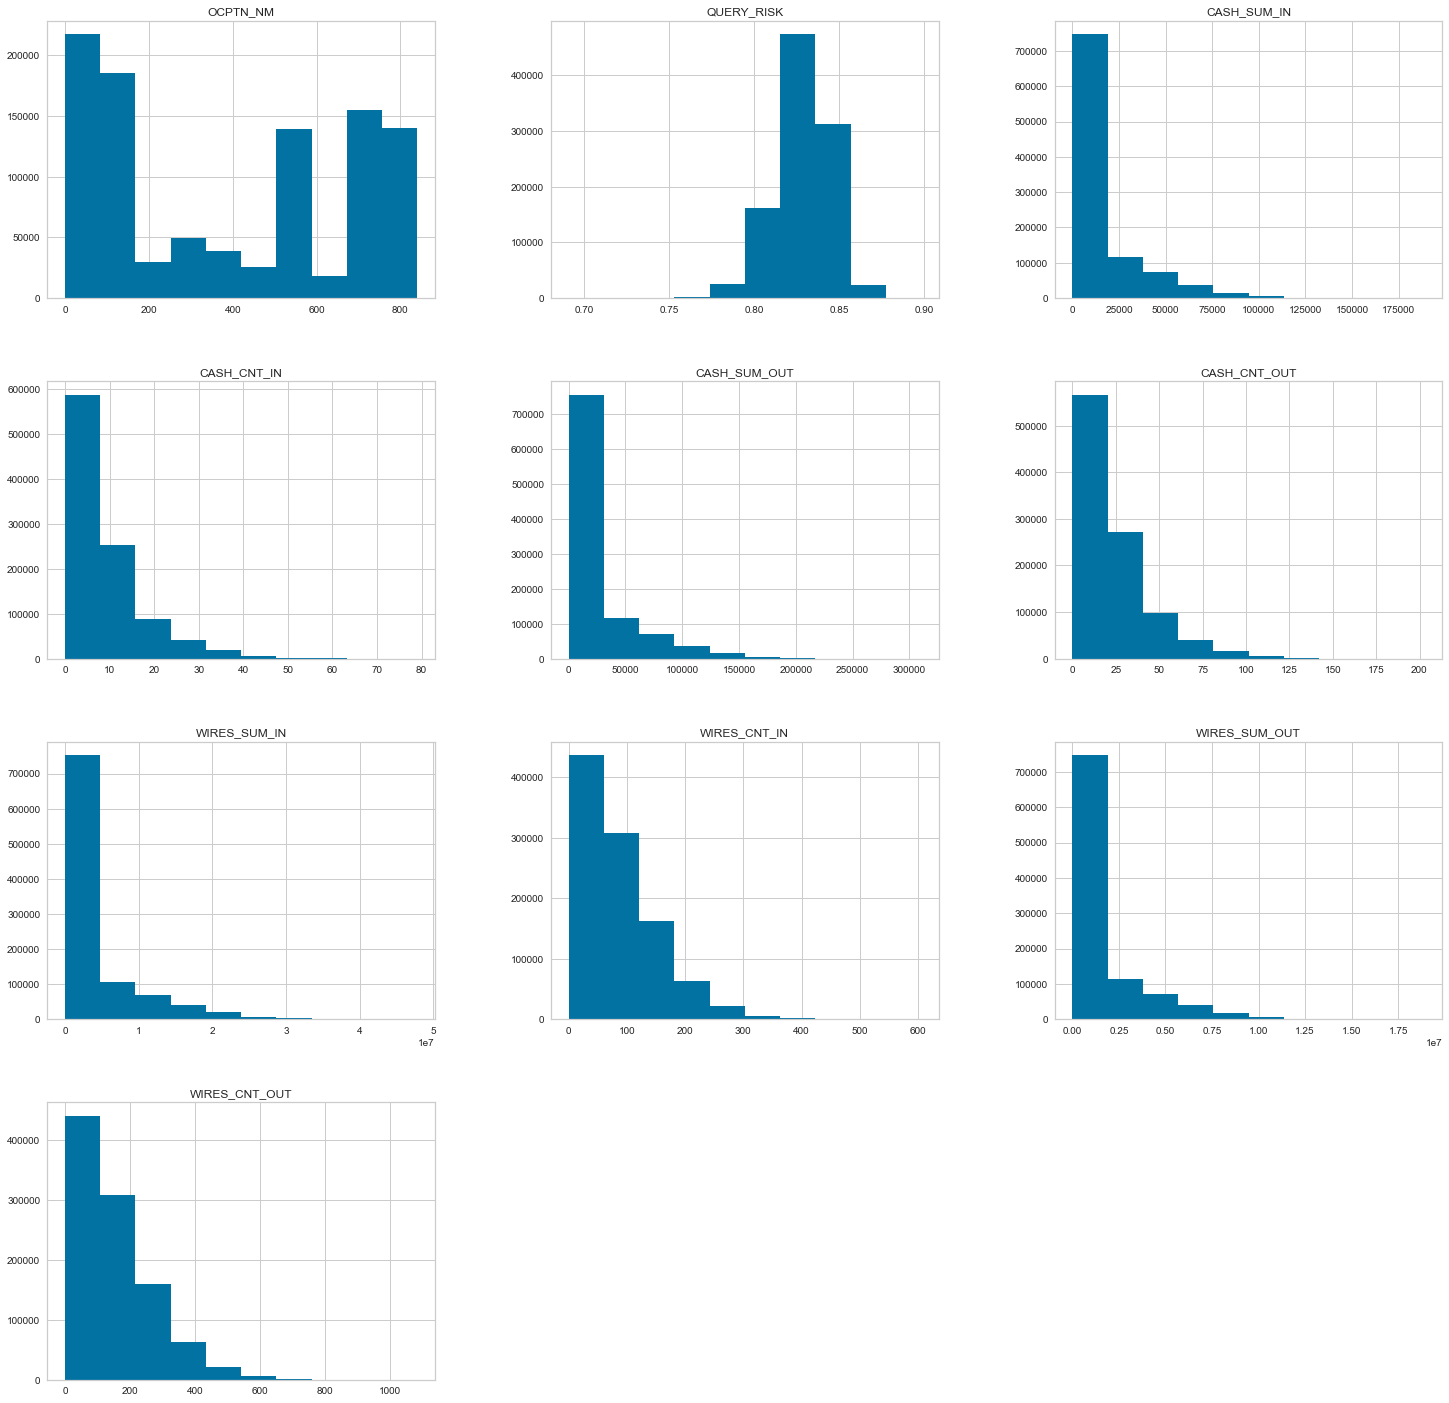

In [88]:
df_train_3_numeric.hist(figsize=(25,25))

***Using log transform to remove skewness and Kurtosis***

In [89]:
# Added utility list of categorical for scalability.
numericals = df_train_3_numeric.columns #"Total Households For Period Of Construction Built Between 1981 And 190"
categoricals = df_train_categorical.columns #[col for col in df_train.columns if col not in categoricals]

In [90]:
df_train_4_numerical = df_train_3_numeric
df_train_4_categorical = df_train_3_categorical


In [91]:
y_3.shape

(1000000,)

In [92]:
df_train_4_numerical.isnull().sum()

OCPTN_NM         0
QUERY_RISK       0
CASH_SUM_IN      0
CASH_CNT_IN      0
CASH_SUM_OUT     0
CASH_CNT_OUT     0
WIRES_SUM_IN     0
WIRES_CNT_IN     0
WIRES_SUM_OUT    0
WIRES_CNT_OUT    0
dtype: int64

### Feature Engineering 5-  Checking correlation between numerical variables

In [93]:

corr_matrix=df_train_4_numerical.corr()

upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.70)]

<ipython-input-93-e723ac971bc0>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


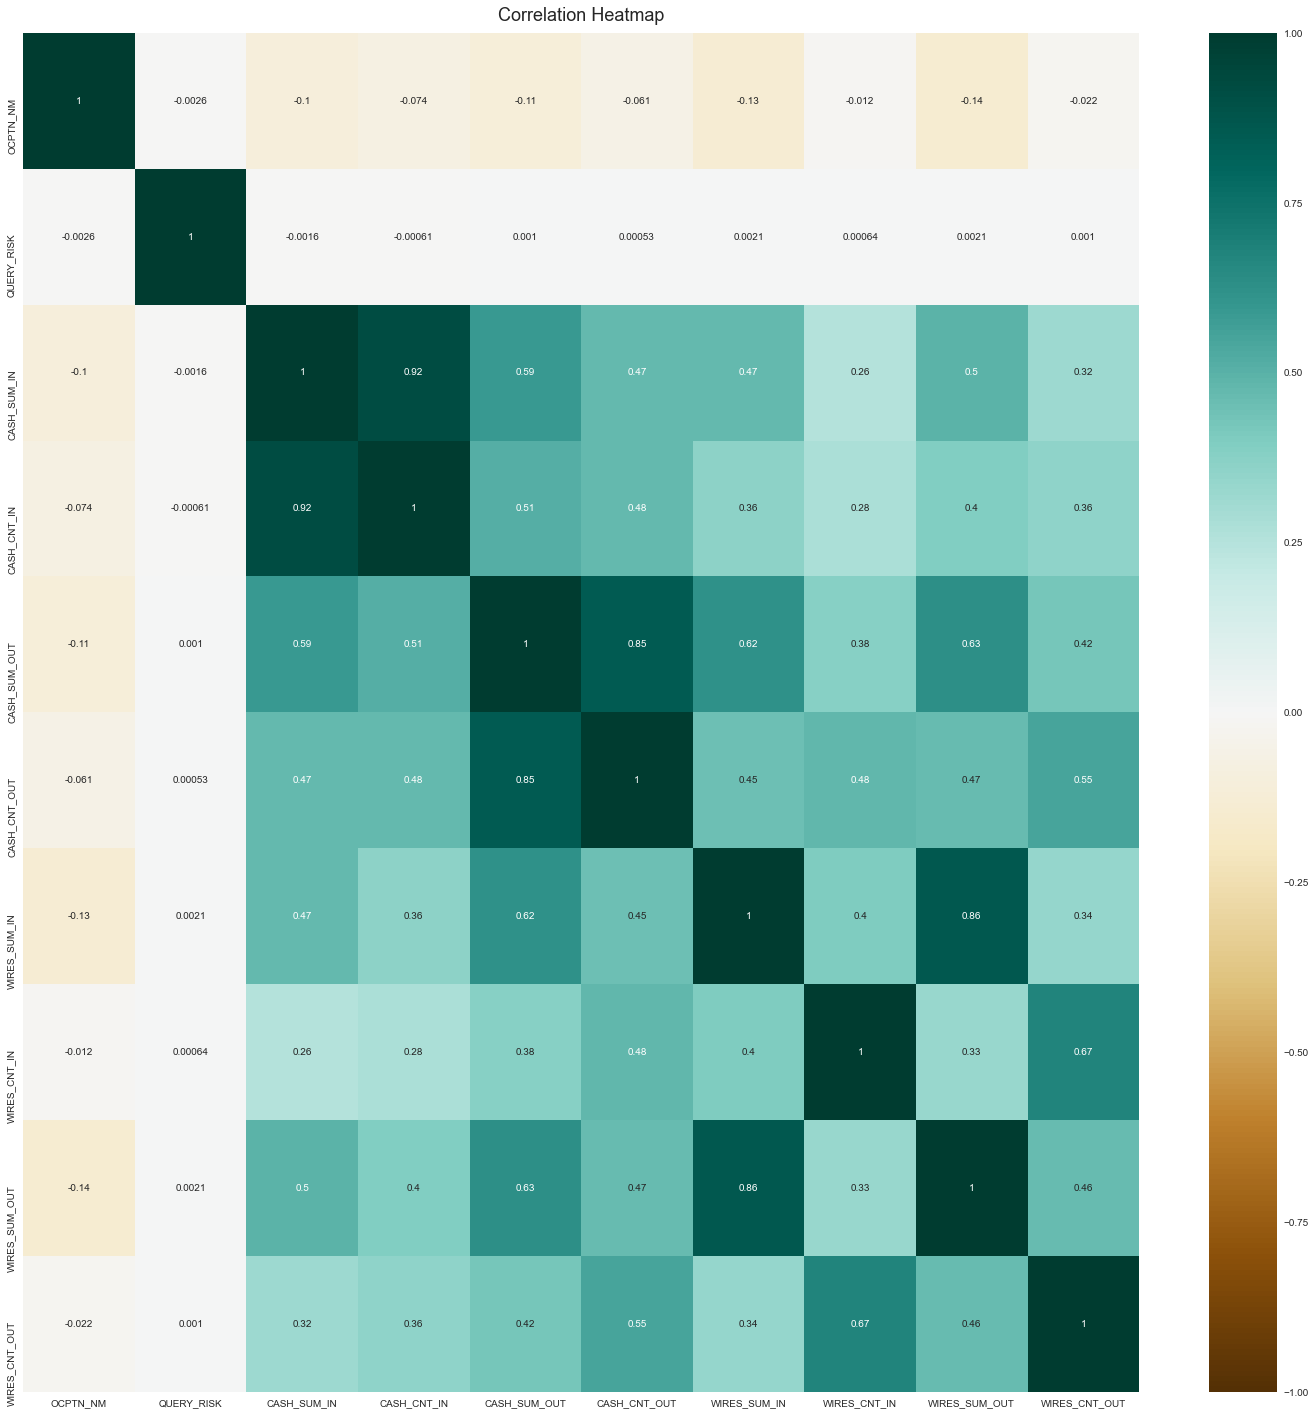

In [94]:
plt.figure(figsize=(25, 25))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

array([[<AxesSubplot: title={'center': 'CASH_CNT_IN'}>,
        <AxesSubplot: title={'center': 'CASH_CNT_OUT'}>],
       [<AxesSubplot: title={'center': 'WIRES_SUM_OUT'}>,
        <AxesSubplot: >]], dtype=object)

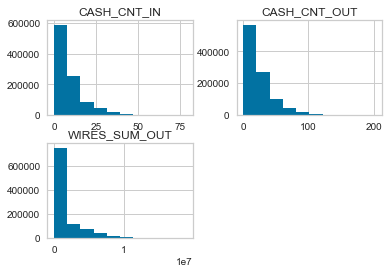

In [95]:
df_train_4_numerical[to_drop].hist()

In [96]:
df_train_4_numerical = df_train_4_numerical.drop(to_drop,axis=1) 
#df_test_4_numerical = df_train_4_numerical.drop(to_drop,axis=1)


In [97]:
corr_matrix=df_train_4_numerical.corr()

upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.70)]

<ipython-input-97-e723ac971bc0>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


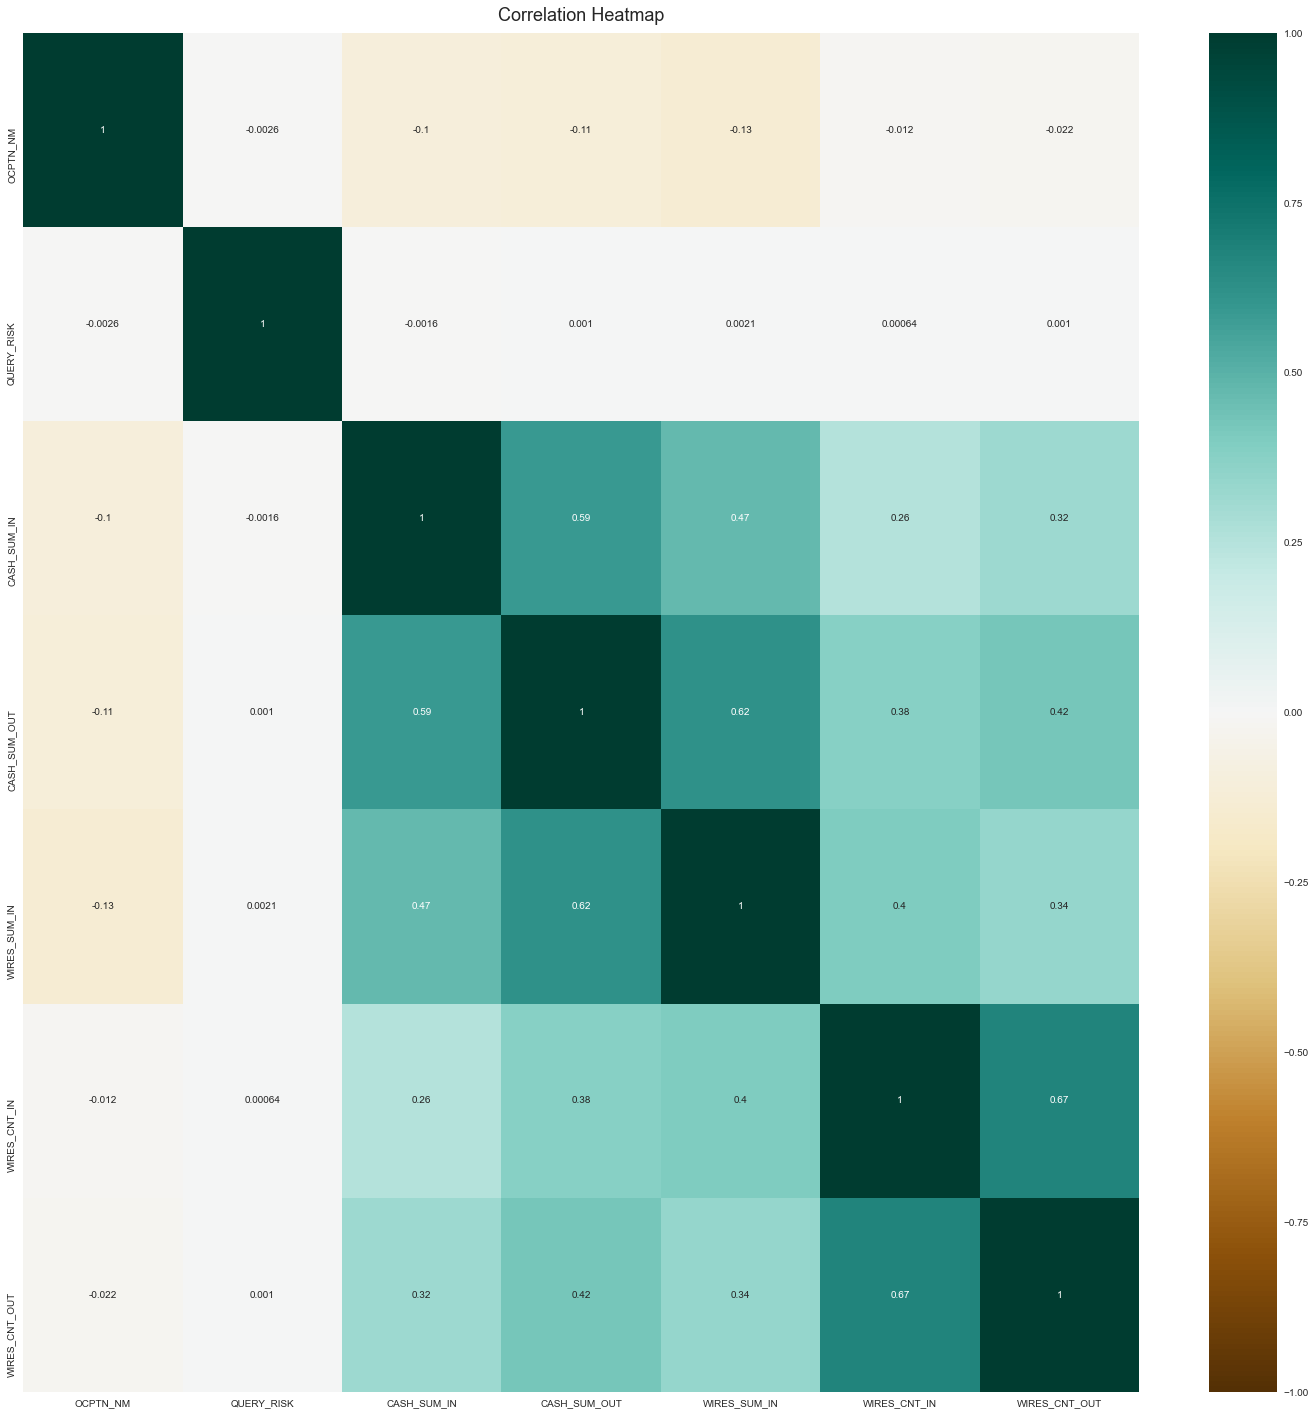

In [98]:
plt.figure(figsize=(25, 25))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap_cor_rem.png', dpi=300, bbox_inches='tight')

In [99]:
#Adding back possible categoricals before scaling
# df_train_4_combined= pd.concat([df_train_4_numerical,df_train_4[categoricals]],axis=1)

**Thus We removed correlated features, we chose all variables which had correlation > 0.80**

### Feature Engineering 4.2 -  Fixing skewness (Using log transformations)

In [100]:
#We have already tried with removal of skewness using box cox transformation but it did'nt work out well, so we removed collinearity and now try log transformation

array([[<AxesSubplot: title={'center': 'OCPTN_NM'}>,
        <AxesSubplot: title={'center': 'QUERY_RISK'}>,
        <AxesSubplot: title={'center': 'CASH_SUM_IN'}>],
       [<AxesSubplot: title={'center': 'CASH_SUM_OUT'}>,
        <AxesSubplot: title={'center': 'WIRES_SUM_IN'}>,
        <AxesSubplot: title={'center': 'WIRES_CNT_IN'}>],
       [<AxesSubplot: title={'center': 'WIRES_CNT_OUT'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

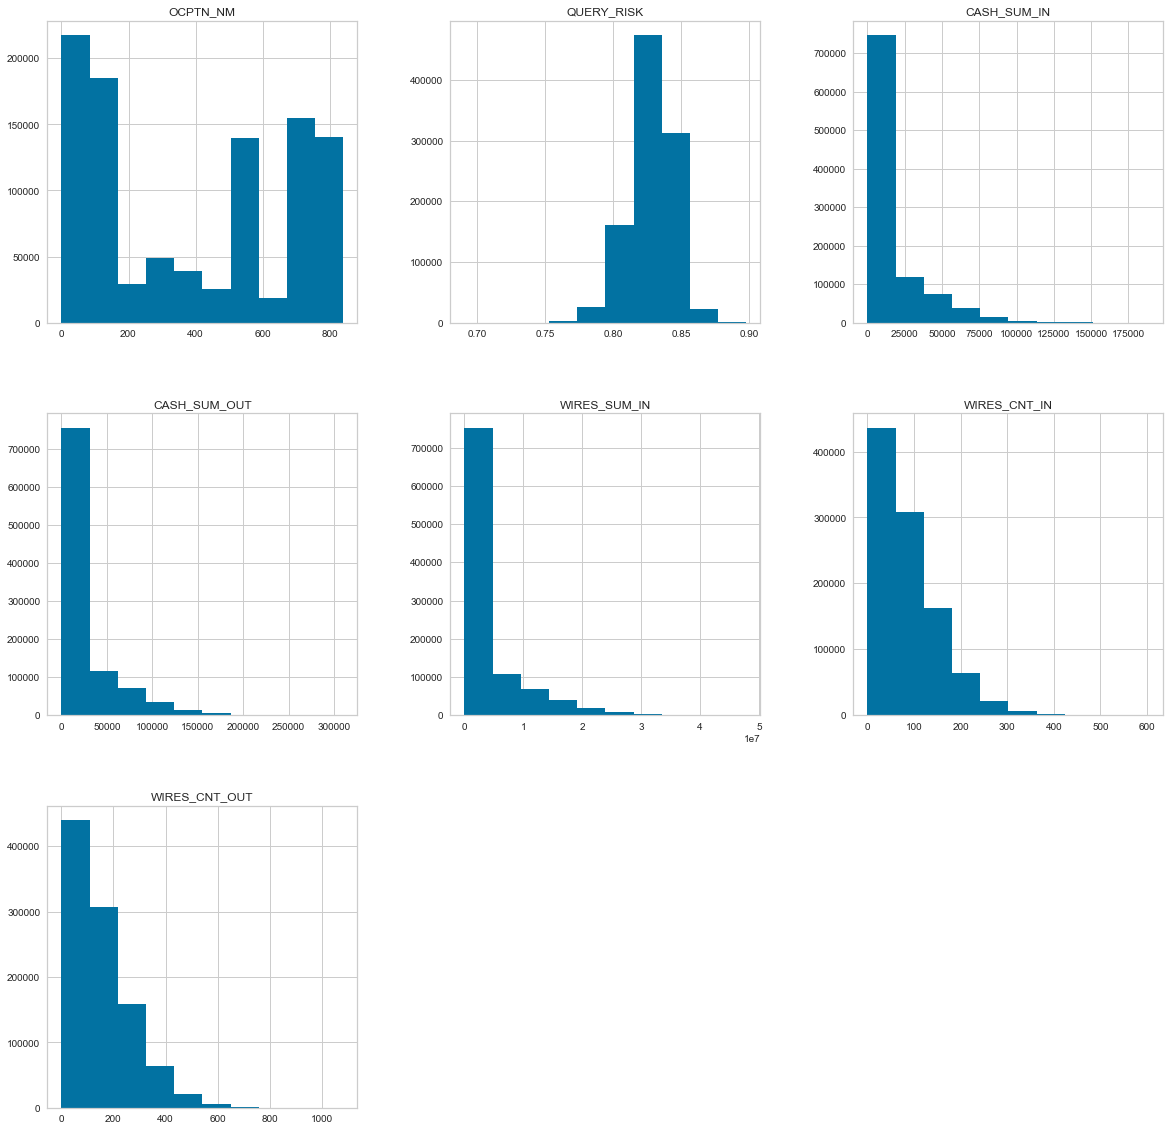

In [101]:
df_train_4_numerical.hist(figsize=(20,20))

In [102]:
# df_train_4_combined = df_train_4_numerical.copy()
# y_4 = y_3.copy()

In [103]:
df_train_4_numerical.isnull().sum().sum()

0

In [104]:
df_train_5_numerical= df_train_4_numerical.copy()

In [105]:
df_train_5_categorical= df_train_4_categorical.copy()

In [106]:
cols_skewed = [col for col in df_train_5_numerical.columns]

In [107]:
def apply_log_trf(np_array_col):
    return np.sign(np_array_col) * np.log(np.abs(np_array_col)+1)

In [108]:
for col in cols_skewed:
    df_train_5_numerical[col]= apply_log_trf(df_train_5_numerical[col])

array([[<AxesSubplot: title={'center': 'OCPTN_NM'}>,
        <AxesSubplot: title={'center': 'QUERY_RISK'}>,
        <AxesSubplot: title={'center': 'CASH_SUM_IN'}>],
       [<AxesSubplot: title={'center': 'CASH_SUM_OUT'}>,
        <AxesSubplot: title={'center': 'WIRES_SUM_IN'}>,
        <AxesSubplot: title={'center': 'WIRES_CNT_IN'}>],
       [<AxesSubplot: title={'center': 'WIRES_CNT_OUT'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

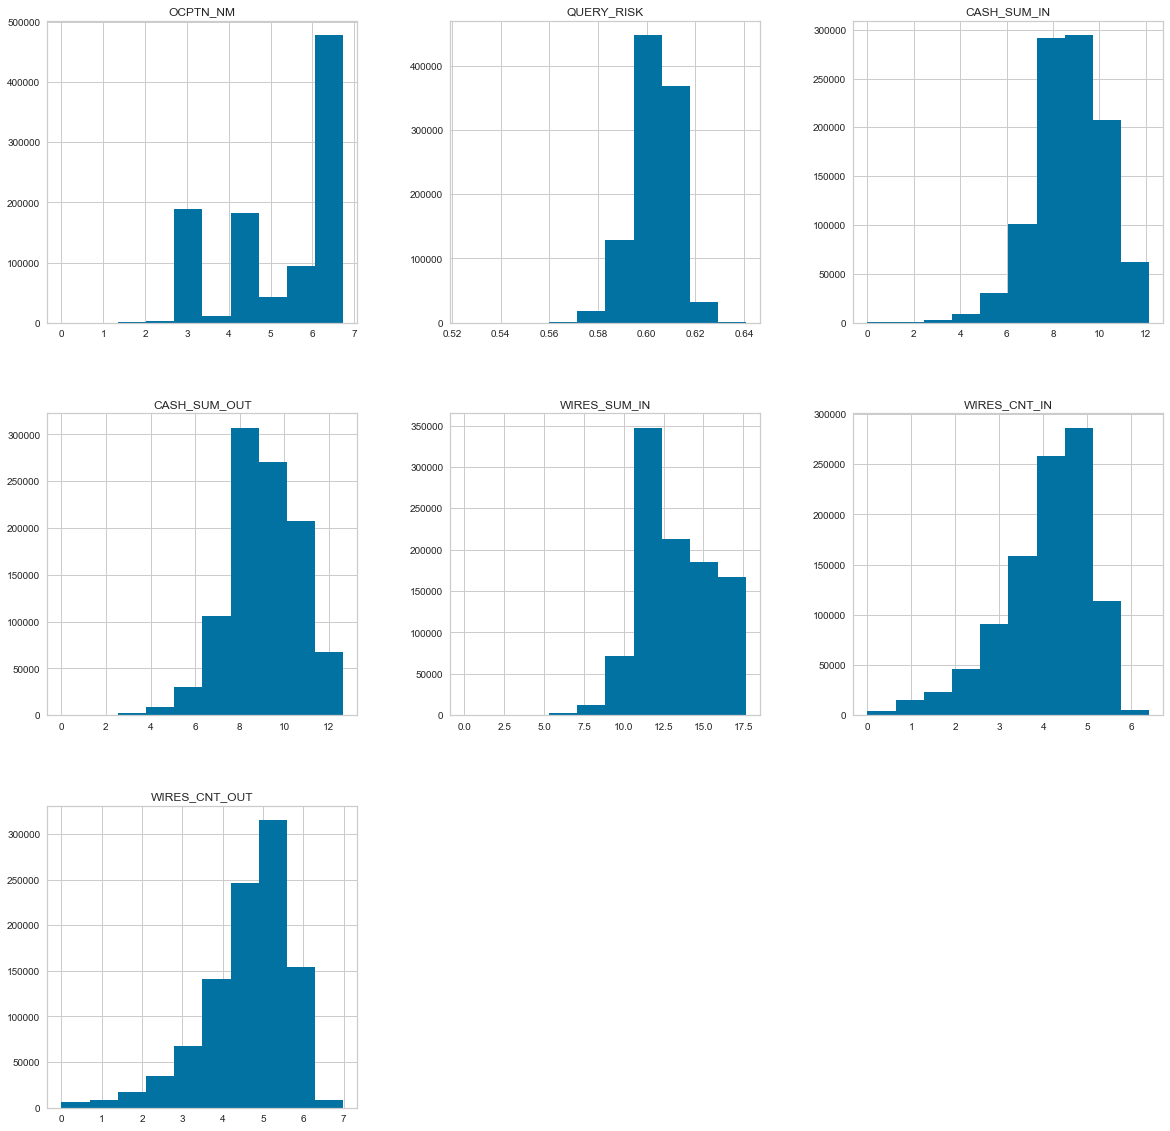

In [109]:
df_train_5_numerical.hist(figsize= (20,20))

In [110]:
df_train_5_numerical

,OCPTN_NM,QUERY_RISK,CASH_SUM_IN,CASH_SUM_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_CNT_OUT
0,4.499810,0.605207,7.855074,7.956008,11.167261,4.143135,3.583519
1,4.499810,0.607027,8.018461,8.477828,12.552955,4.343805,5.030438
2,4.499810,0.597728,7.389299,8.155882,8.940236,1.945910,3.044522
3,4.499810,0.605351,8.185362,7.571444,11.913405,4.276666,5.476464
4,4.499810,0.602915,7.453865,9.487833,11.433005,4.574711,5.198497
...,...,...,...,...,...,...,...
999995,6.148468,0.601223,9.849354,10.380063,13.986491,3.258097,5.164786
999996,6.148468,0.590200,8.661571,8.520536,12.406991,3.988984,5.823046
999997,4.189655,0.583605,7.763130,9.680219,14.922181,4.234107,4.828314
999998,5.446737,0.613218,10.215141,8.131531,13.757328,2.302585,2.564949


***This transformation seems to be working much better than box cox, so we apply this on test dataset***

In [111]:
#for col in cols_skewed:
#    df_test_5_combined[col]= apply_log_trf(df_test_5_combined[col])

In [112]:
#df_test_5_combined.hist(figsize=(20,20))

# Transformation 

### 1. Transformation - Scaling

In [113]:
# Using min max scaler for scaling we wanted our values to lie between 0-1 because if we use any other scaling it makes tnterpretation difficult if for eg features like 
# total households have values lesss than 0. Then during cluster analysis such negative values cause problem in interpretation. 

In [114]:

scaler = MinMaxScaler()
#df_train_4_numerical
df_train_5_numerical_scaled= pd.DataFrame(scaler.fit_transform(df_train_5_numerical),columns=df_train_5_numerical.columns)
_= scaler.transform(df_train_5_numerical)
# df_test_5_combined_scaled= pd.DataFrame(scaler.transform(df_test_5_combined),columns=df_test_5_combined.columns)

In [115]:
#'BIRTH_DT', 'CUST_ADD_DT' , 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'NAME','GENDER','occupation_risk'

In [116]:
df_train_5_categorical.COUNTRY_RISK_RESIDENCY.value_counts()

0    990109
2      9200
1       691
Name: COUNTRY_RISK_RESIDENCY, dtype: Int64

In [117]:
y_3

0         0
1         0
2         0
3         0
4         0
         ..
999995    2
999996    0
999997    2
999998    2
999999    2
Name: RISK, Length: 1000000, dtype: int64

In [118]:
df_train_5_categorical.COUNTRY_RISK_INCOME.replace(['Low','Moderate','High'],[0,1,2],inplace=True)
df_train_5_categorical.COUNTRY_RISK_RESIDENCY.replace(['Low','Moderate','High'],[0,1,2],inplace=True)


In [119]:
df_train_5_categorical.head()


,GENDER,OCPTN_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY
0,0.0,2.0,1,1,0,0,0
1,1.0,2.0,1,1,0,0,0
2,1.0,2.0,1,1,0,0,0
3,0.0,2.0,1,1,0,0,0
4,0.0,2.0,1,1,0,0,0


In [120]:
df_train_5_categorical.isnull().sum().sum()

0

In [121]:
df_train_5_numerical_scaled.shape

(1000000, 7)

In [122]:
df_train_combined= pd.concat([df_train_5_categorical.reset_index(),df_train_5_numerical_scaled.reset_index()],axis=1).drop(['index'],axis=1) #df_train_4_categorical #

In [123]:
df_train_combined

,GENDER,OCPTN_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,OCPTN_NM,QUERY_RISK,CASH_SUM_IN,CASH_SUM_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_CNT_OUT
0,0.0,2.0,1,1,0,0,0,0.668164,0.691948,0.646548,0.629197,0.631532,0.646670,0.512780
1,1.0,2.0,1,1,0,0,0,0.668164,0.707684,0.659996,0.670464,0.709896,0.677991,0.719825
2,1.0,2.0,1,1,0,0,0,0.668164,0.627291,0.608210,0.645004,0.505589,0.303722,0.435653
3,0.0,2.0,1,1,0,0,0,0.668164,0.693197,0.673733,0.598784,0.673728,0.667512,0.783649
4,0.0,2.0,1,1,0,0,0,0.668164,0.672137,0.613524,0.750340,0.646560,0.714031,0.743874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.0,0.0,0,1,0,0,2,0.912968,0.657506,0.810696,0.820902,0.790965,0.508531,0.739050
999996,1.0,0.0,0,1,0,0,0,0.912968,0.562212,0.712930,0.673842,0.701641,0.622609,0.833243
999997,0.0,2.0,0,1,0,0,2,0.622110,0.505202,0.638980,0.765555,0.843880,0.660869,0.690903
999998,1.0,2.0,0,1,0,0,2,0.808770,0.761199,0.840804,0.643078,0.778005,0.359393,0.367029


In [124]:
#df_train_5_combined_scaled = df_train_5_combined_scaled.fillna(method='bfill')
#df_test_5_combined_scaled = df_test_5_combined_scaled.fillna(method='bfill')

In [125]:
df_train_combined_2 = df_train_combined.copy()
y_combined =  y_3.copy()

In [126]:
df_train_combined_2.shape

(1000000, 14)

In [127]:
# there seems to be some values nan because of log 0 lets fill with mean
#imputer = KNNImputer(n_neighbors=2)

In [128]:
#df_train_6_combined_scaled= pd.DataFrame(imputer.fit_transform(df_train_6_combined_scaled),columns=df_train_6_combined_scaled.columns)

In [129]:
#df_test_6_combined_scaled= pd.DataFrame(imputer.fit_transform(df_test_6_combined_scaled),columns=df_test_6_combined_scaled.columns)

In [130]:
#df_train_6_combined_scaled

In [131]:
#df_test_6_combined_scaled


In [132]:
df_train_combined_2

,GENDER,OCPTN_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,OCPTN_NM,QUERY_RISK,CASH_SUM_IN,CASH_SUM_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_CNT_OUT
0,0.0,2.0,1,1,0,0,0,0.668164,0.691948,0.646548,0.629197,0.631532,0.646670,0.512780
1,1.0,2.0,1,1,0,0,0,0.668164,0.707684,0.659996,0.670464,0.709896,0.677991,0.719825
2,1.0,2.0,1,1,0,0,0,0.668164,0.627291,0.608210,0.645004,0.505589,0.303722,0.435653
3,0.0,2.0,1,1,0,0,0,0.668164,0.693197,0.673733,0.598784,0.673728,0.667512,0.783649
4,0.0,2.0,1,1,0,0,0,0.668164,0.672137,0.613524,0.750340,0.646560,0.714031,0.743874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.0,0.0,0,1,0,0,2,0.912968,0.657506,0.810696,0.820902,0.790965,0.508531,0.739050
999996,1.0,0.0,0,1,0,0,0,0.912968,0.562212,0.712930,0.673842,0.701641,0.622609,0.833243
999997,0.0,2.0,0,1,0,0,2,0.622110,0.505202,0.638980,0.765555,0.843880,0.660869,0.690903
999998,1.0,2.0,0,1,0,0,2,0.808770,0.761199,0.840804,0.643078,0.778005,0.359393,0.367029


### 2. Transformation - Train Test Split

In [133]:
#Splitting data into train test split
X_train, X_test, y_train, y_test = train_test_split(df_train_combined_2,y_combined, test_size=0.20, random_state=42)

# Unsupervised Phase

### 1. Modelling Process - Segmentation using clustering

In [134]:
# We start with clustering analysis of dtaaste to identify segments.

In [135]:
len(X_train.columns)
y_train

566853    0
382311    0
241519    0
719220    1
905718    0
         ..
259178    0
365838    0
131932    2
671155    0
121958    1
Name: RISK, Length: 800000, dtype: int64

#### Auto encoder to reduce dimensions

In [136]:
# elbow score plot with Yellowbrick
def elbowplot(df, elbowmetric, model):
    '''
    Function takes in a dataframe elbow metric and model to Visualize different
    metrics for clustering.
    
    Args:
    df: Dataframe to remove skewness from.
    elbowmetric: Can be one of "distortion", "silhouette", "calinski_harabasz"
    
    Returns:
    None
    
    '''
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    print(df.shape)
    vis = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  
    
    
    
# call elbow plot for each of 3 alternative metrics
    # distortion = mean sum of squared distances to center
    # silhouette = mean ratio of intra-cluster and nearest-cluster distance
    # calinski = ratio of within to between cluster dispersion



In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split


**Implemnted auto encoder to reduce dimension 16 to 2 to ease k means and future scalability purpose**

In [138]:
class CustomDataset(Dataset):
    """Custom Dataset."""

    def __init__(self, X_train):
        self.X_train = X_train
        

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
        #if isinstance(idx, torch.Tensor):
        #    idx = idx.tolist()

        #print(type(self.X_train.iloc[idx].values))
        return torch.from_numpy(self.X_train.iloc[idx].values.astype(float)), torch.from_numpy(self.X_train.iloc[idx].values.astype(float)) # make changes to masking here for encoder


In [139]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
    def forward(self, x):
        print(x.shape)
        ls = self.encoder(x)
        x = self.decoder(ls)
        return x,ls



In [140]:
def train(X_train,y_train,X_test,y_test,latent_dim, n_epochs=100):
    """Trains the model.
    Args:
        csv_file (str): Absolute path of the dataset used for training.
        n_epochs (int): Number of epochs to train.
    """
    # Load dataset
    train_set = CustomDataset(X_train)
    val_set = CustomDataset(X_test)

    # Split into training and test
    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #trainset, testset = random_split(dataset, [train_size, test_size])

    # Dataloaders
    trainloader = DataLoader(train_set, batch_size=100000, shuffle=True)
    valloader = DataLoader(val_set, batch_size=100000, shuffle=False)
    

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the model
    net = Autoencoder(input_dim=X_train.shape[1], latent_dim=latent_dim)
    
    net = net.to(device)

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam(net.parameters(), weight_decay=0.0001)

    # Train the net
    loss_per_iter = []
    loss_per_batch = []
    print('Starting Training')
    for epoch in range(n_epochs):
        running_loss = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):
            #if i==3:
            #    break
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(type(labels))

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs,latent_space = net(inputs.float())
            
            #print(outputs.shape,labels.shape)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Save loss to plot
            running_loss += loss.item()
            loss_per_iter.append(loss.item())
            print(f"Epoch Number {epoch}/{n_epochs} batch {i}/{len(trainloader)} current_loss{running_loss / (i + 1)}")
            

        loss_per_batch.append(running_loss / (i + 1))
        
        running_loss = 0.0

    # Comparing training to test
    dataiter = iter(valloader)
    inputs,labels = next(dataiter)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs,latent_space = net(inputs.float())
    print("Root mean squared error")
    print("Training:", np.sqrt(loss_per_batch[-1]))
    print("Test", np.sqrt(criterion(labels.float(), outputs).detach().cpu().numpy()))

    # Plot training loss curve
    plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
    print((np.arange(len(loss_per_iter), step=4) + 3).shape,loss_per_batch)
    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return net

In [141]:
latent_dim=X_train.shape[1]

Starting Training
torch.Size([100000, 14])
Epoch Number 0/25 batch 0/8 current_loss0.5496306419372559
torch.Size([100000, 14])
Epoch Number 0/25 batch 1/8 current_loss0.5395341217517853
torch.Size([100000, 14])
Epoch Number 0/25 batch 2/8 current_loss0.5299142003059387
torch.Size([100000, 14])
Epoch Number 0/25 batch 3/8 current_loss0.5205004811286926
torch.Size([100000, 14])
Epoch Number 0/25 batch 4/8 current_loss0.5113186001777649
torch.Size([100000, 14])
Epoch Number 0/25 batch 5/8 current_loss0.5021046052376429
torch.Size([100000, 14])
Epoch Number 0/25 batch 6/8 current_loss0.4927553491933005
torch.Size([100000, 14])
Epoch Number 0/25 batch 7/8 current_loss0.48326000198721886
torch.Size([100000, 14])
Epoch Number 1/25 batch 0/8 current_loss0.3963044285774231
torch.Size([100000, 14])
Epoch Number 1/25 batch 1/8 current_loss0.38620011508464813
torch.Size([100000, 14])
Epoch Number 1/25 batch 2/8 current_loss0.37479695677757263
torch.Size([100000, 14])
Epoch Number 1/25 batch 3/8 cu

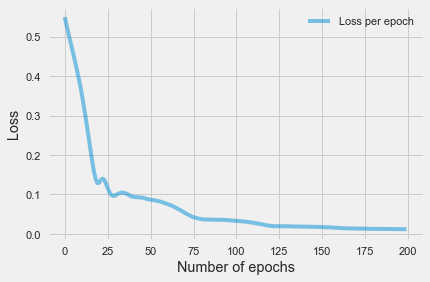

In [593]:
model= train(X_train,y_train,X_test,y_test,latent_dim, n_epochs=25) # 318211

In [594]:
torch.save(model.state_dict(), f'./dnn_ae_v{int(version)}_ls_{latent_dim}.pth')

In [143]:
X_train

,GENDER,OCPTN_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,OCPTN_NM,QUERY_RISK,CASH_SUM_IN,CASH_SUM_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_CNT_OUT
566853,0.0,0.0,1,1,0,0,0,0.995883,0.749783,0.646754,0.603895,0.662370,0.583384,0.585876
382311,1.0,0.0,1,1,0,0,0,0.483785,0.652486,0.688686,0.757643,0.684759,0.773516,0.775011
241519,1.0,0.0,1,1,0,0,0,0.977962,0.645351,0.692256,0.733413,0.698098,0.658590,0.704020
719220,1.0,2.0,1,1,0,0,0,0.926890,0.664801,0.769064,0.583466,0.798674,0.613688,0.573425
905718,1.0,2.0,1,1,0,0,0,0.749838,0.796337,0.683021,0.592046,0.631008,0.622609,0.343124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0.0,0.0,1,1,0,0,0,0.977962,0.695779,0.663790,0.601113,0.507008,0.597583,0.471614
365838,1.0,0.0,1,1,0,0,0,0.483785,0.732791,0.688389,0.529645,0.571398,0.508531,0.454760
131932,1.0,2.0,1,1,0,0,0,0.668164,0.718800,0.813870,0.880837,0.878773,0.848787,0.775646
671155,0.0,2.0,1,1,0,0,0,0.926890,0.617483,0.666499,0.715477,0.586222,0.303722,0.547856


In [144]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [145]:
X = X_train.reset_index().drop(['index'],axis=1)

In [146]:
'''range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,)
    print(f'Fit started for {n_clusters}')
    clusterer.fit(X)
    print(f'Fit ended for {n_clusters}')
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()'''

'range_n_clusters = [2, 3, 4, 5, 6]\n\nfor n_clusters in range_n_clusters:\n    # Create a subplot with 1 row and 2 columns\n    fig, (ax1, ax2) = plt.subplots(1, 2)\n    fig.set_size_inches(18, 7)\n\n    # The 1st subplot is the silhouette plot\n    # The silhouette coefficient can range from -1, 1 but in this example all\n    # lie within [-0.1, 1]\n    ax1.set_xlim([-0.1, 1])\n    # The (n_clusters+1)*10 is for inserting blank space between silhouette\n    # plots of individual clusters, to demarcate them clearly.\n    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])\n\n    # Initialize the clusterer with n_clusters value and a random generator\n    # seed of 10 for reproducibility.\n    clusterer = KMeans(n_clusters=n_clusters, random_state=10,)\n    print(f\'Fit started for {n_clusters}\')\n    clusterer.fit(X)\n    print(f\'Fit ended for {n_clusters}\')\n    cluster_labels = clusterer.predict(X)\n\n    # The silhouette_score gives the average value for all the samples.\n    # Th

#### Producing reduced latent space corrosponding to each row in df

In [147]:
#latent_dim = 19

In [148]:
#latent_dim= 10 

In [149]:
# Now we do the same for entire dataset
#We use tsne on encoder space
train_set = CustomDataset(df_train_combined_2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainloader = DataLoader(train_set, batch_size=int(df_train_combined_2.shape[0]/2), shuffle=True,drop_last=True) #deliberate different batching to induce batch randomness in clustering
#model = TheModelClass(*args, **kwargs)
model= Autoencoder(input_dim=df_train_combined_2.shape[1], latent_dim=latent_dim)
model.load_state_dict(torch.load(f'./dnn_ae_v{int(version)}_ls_{14}.pth'))

<All keys matched successfully>

In [150]:
bt = trainloader.sampler

In [151]:
ls= []
model.eval()
for i, (inputs, labels) in tqdm(enumerate(trainloader)):
    #print(i)
    outputs,latent_space = model(inputs.float())
    #print(outputs.unsqueeze(dim = 0).shape)
   # break
    ls.append(latent_space.unsqueeze(dim = 0).cpu().detach().numpy())

0it [00:00, ?it/s]

torch.Size([500000, 14])


1it [02:23, 143.72s/it]

torch.Size([500000, 14])


2it [04:50, 145.06s/it]


In [152]:
ls_batch_rep = np.stack(ls, axis=1 ).squeeze()


#### Sub sampling data for cliustering

In [153]:
ls_batch_reshaped= ls_batch_rep.reshape(((ls_batch_rep.shape[1]*2,latent_dim))) #change dim as per latent_dim

In [154]:
#This contains auto encoder latent space rep we apply kmean on this and also separately take models

In [177]:
batch_factor =75


In [178]:
remaining_samples = np.arange(ls_batch_reshaped.shape[0]) 
random_batch = np.random.choice(remaining_samples, int(ls_batch_reshaped.shape[0] / batch_factor), replace = False) 

In [179]:
subsamp = ls_batch_reshaped[random_batch]

In [180]:
subsamp.shape

(13333, 14)

#### Choosing the Appropriate Number of Clusters
***We need to cluster and choose appropriate number of clusters, we will employ:***

1. ***The distortion score*** - The distortion is the sum of square errors (SSE) – that's 3 things that need to take place; determine the error, square it, then finally take the sum. The “error” in this case is the difference between each data point coordinates and the centroid coordinates.
2. ***Silhouette Score***- The value of the silhouette coefﬁcient is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters
3. ***Calinski_harabasz Score*** - is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters, the higher the score , the better the performances

***These are often used as complementary evaluation techniques rather than one being preferred over the other. To perform the elbow method, run several k-means, increment k with each iteration, and record the SSE:***

Fit started for 2
Fit ended for 2
For n_clusters = 2 The average silhouette_score is : 0.6757282
Fit started for 3
Fit ended for 3
For n_clusters = 3 The average silhouette_score is : 0.69428444
Fit started for 4
Fit ended for 4
For n_clusters = 4 The average silhouette_score is : 0.69733465
Fit started for 5
Fit ended for 5
For n_clusters = 5 The average silhouette_score is : 0.71350765
Fit started for 6
Fit ended for 6
For n_clusters = 6 The average silhouette_score is : 0.7374792


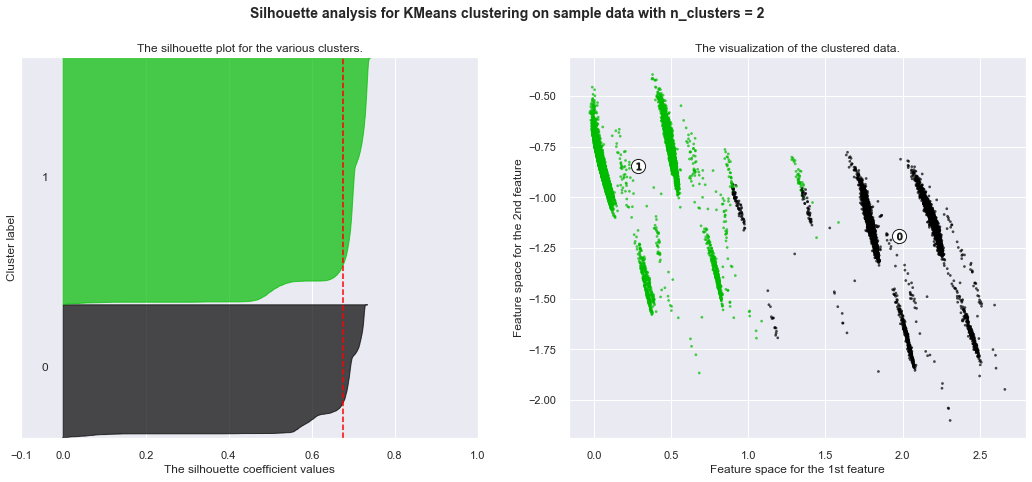

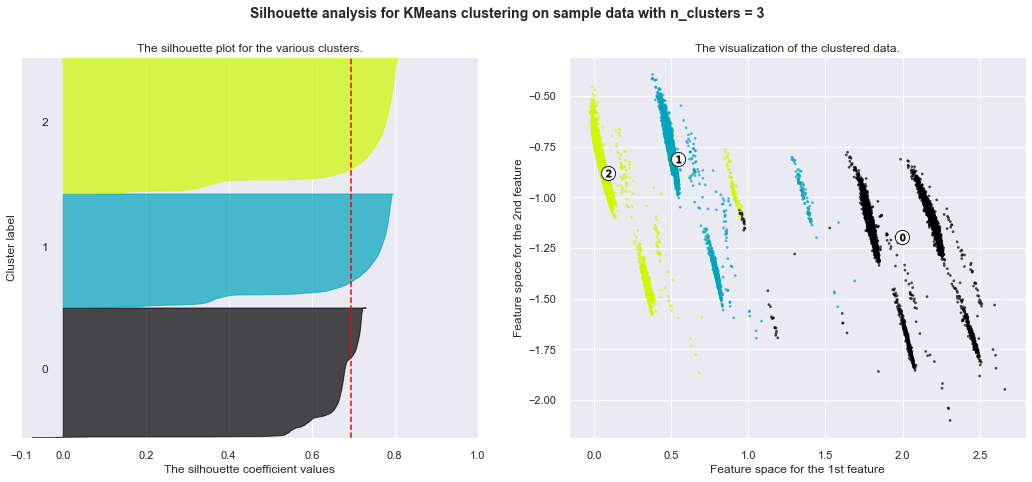

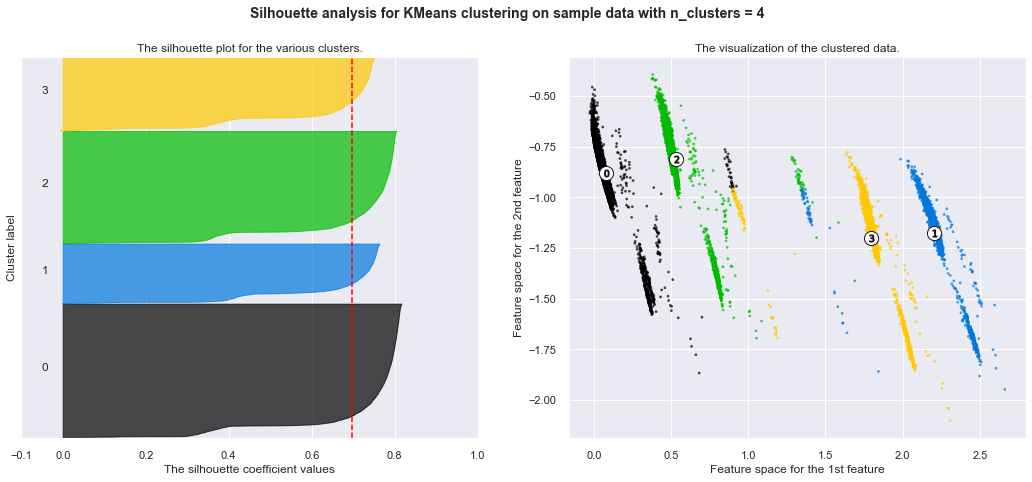

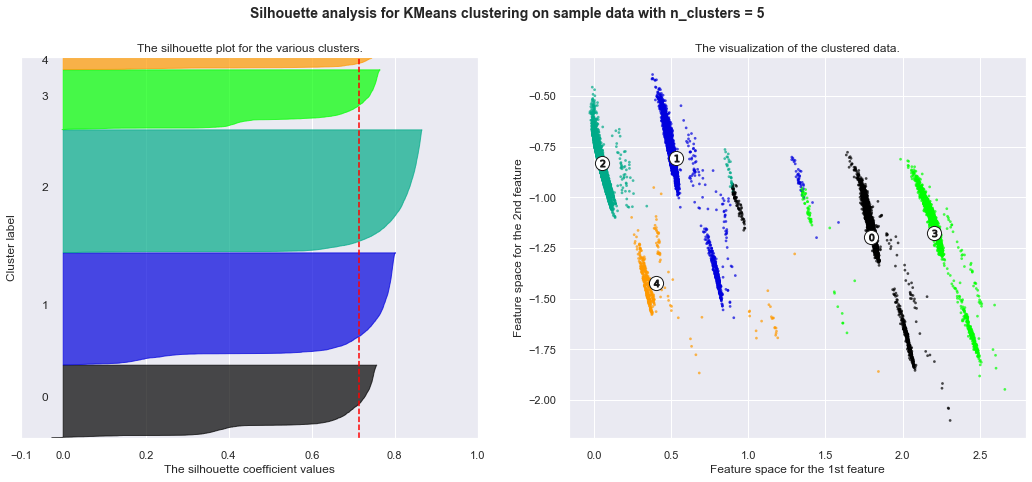

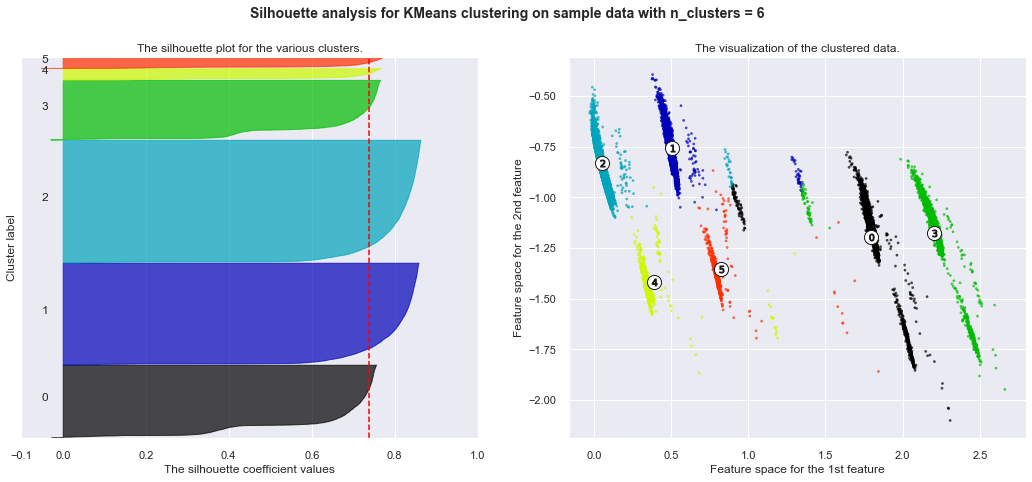

In [181]:
range_n_clusters = [2, 3, 4, 5, 6]
X= subsamp
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,)
    print(f'Fit started for {n_clusters}')
    clusterer.fit(X)
    print(f'Fit ended for {n_clusters}')
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [219]:
from sklearn.cluster import DBSCAN
kmeans_kwargs = {"init": "random","n_init": 20,"max_iter": 1000,"random_state": 1984}
kmeans= KMeans(n_clusters=6, **kmeans_kwargs) # because of high silhouette score

dbscan =  DBSCAN(eps=0.75,min_samples=150)
#dbscan.fit(subsamp)

In [183]:
risk_df.RISK.value_counts()

low       600000
medium    350000
high       50000
Name: RISK, dtype: int64

In [213]:
clusters = dbscan.fit_predict(subsamp)

In [220]:
kmeans.fit(subsamp)
clusters= kmeans.predict(subsamp)

#### Cluster Visualization using TSNE

In [221]:
from sklearn.manifold import TSNE
Xtsne = TSNE(n_components=2).fit_transform(subsamp)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = clusters
dftsne.columns = ['x1','x2','cluster']

D:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Visualized on TSNE 2D')

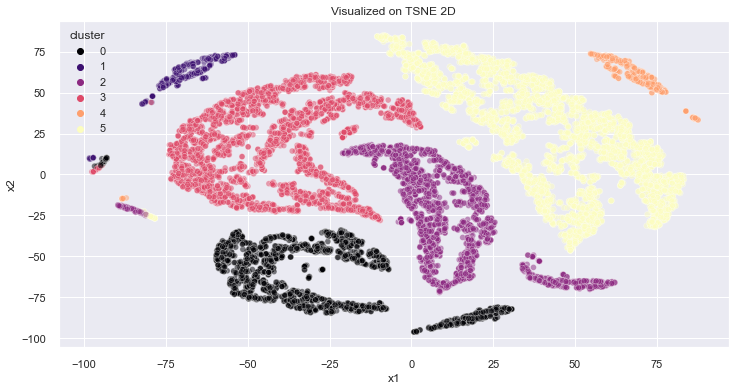

In [222]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax,palette="magma")
ax.set_title('Visualized on TSNE 2D')

In [481]:
# So we will make two different clusters features one with dbscan and other with kmeans that was trained on subsample of data

In [223]:
clusters_k6= kmeans.predict(ls_batch_reshaped) 

In [224]:
clusters_k6.shape

(1000000,)

#### Creating additional feature of cluster for whole training dataframe

In [225]:
df_train_combined_2['clusters_k6']= None
df_train_combined_2['clusters_k6'] = clusters_k6

In [226]:
df_train_combined_2['customer_add_date']= None
df_train_combined_2['customer_add_date'] = customer_add_date

In [227]:
df_train_combined_2['customer_ids']= None
df_train_combined_2['customer_ids'] = customer_ids

In [228]:
df_train_combined_2['customer_names']= None
df_train_combined_2['customer_names'] = customer_names

In [229]:
df_train

,GENDER,OCPTN_NM,OCPTN_RISK,QUERY_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY
0,0.0,89.0,2.0,0.831631,1,1,0,2577.785,2,2851.663,7,70774,62,24244,35,0,0
1,1.0,89.0,2.0,0.834968,1,1,0,3035.502,2,4805.997,15,282929,76,196439,152,0,0
2,1.0,89.0,2.0,0.817983,1,1,0,1617.571,1,3482.809,11,7632,6,33598,20,0,0
3,0.0,89.0,2.0,0.831896,1,1,0,3587.042,5,1940.943,8,149253,71,105896,238,0,0
4,0.0,89.0,2.0,0.827438,1,1,0,1725.524,2,13197.169,43,92318,96,187403,180,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.0,467.0,0.0,0.824348,0,1,0,18945.108,10,32210.000,21,1186467,25,2550098,174,0,2
999996,1.0,467.0,0.0,0.804348,0,1,0,5775.601,7,5015.741,15,244504,53,417992,337,0,0
999997,0.0,65.0,2.0,0.792488,0,1,0,2351.255,2,15997.000,19,3024271,68,948981,124,0,2
999998,1.0,231.0,2.0,0.846363,0,1,0,27312.613,8,3399.000,5,943477,9,376429,12,0,2


In [230]:
df_train_combined_2.head()

,GENDER,OCPTN_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,OCPTN_NM,QUERY_RISK,CASH_SUM_IN,CASH_SUM_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_CNT_OUT,clusters_k6,customer_add_date,customer_ids,customer_names
0,0.0,2.0,1,1,0,0,0,0.668164,0.691948,0.646548,0.629197,0.631532,0.646670,0.512780,3,2007-07-05,935382,"Young, Marie Mildren Coleman"
1,1.0,2.0,1,1,0,0,0,0.668164,0.707684,0.659996,0.670464,0.709896,0.677991,0.719825,5,2019-05-19,2305,Mark Stupar Lecy
2,1.0,2.0,1,1,0,0,0,0.668164,0.627291,0.608210,0.645004,0.505589,0.303722,0.435653,2,2011-08-02,472403,Dean Glasper Wendel Reeves
3,0.0,2.0,1,1,0,0,0,0.668164,0.693197,0.673733,0.598784,0.673728,0.667512,0.783649,5,2001-08-15,227994,"Hulsey, Linda Rauth"
4,0.0,2.0,1,1,0,0,0,0.668164,0.672137,0.613524,0.750340,0.646560,0.714031,0.743874,3,2012-10-28,418265,Carolyn Washington Roberts


**Creating a dataframe to ease our future work**

# Supervised Phase

In [231]:
df_train_combined_2['Risk']= None
df_train_combined_2['Risk']= y_combined # but when use ls use y_combined
df_train_combined_2.to_csv('./train_df_cluster_kmeans_6_v10_100factor_ls14.0.csv')

In [232]:
df_train_combined_2.groupby([ 'clusters_k6','Risk']).size().agg(
  {'count': lambda x: x, 'prop':lambda x: x / x.sum(level=0)}
  ).unstack(level=0).reset_index() 

#cluster 0 max cases of risk 0
# cluster 1 max cases of risk 0
# cluster 2 
#cluster 0 - max risk 0 cases high prop
#cluster 1 - 

,clusters_k6,Risk,count,prop
0,0,0,93124.0,0.599327
1,0,1,54458.0,0.350480
2,0,2,7799.0,0.050193
3,1,0,15818.0,0.595692
4,1,1,9369.0,0.352828
5,1,2,1367.0,0.051480
6,2,0,114132.0,0.597744
7,2,1,67270.0,0.352313
8,2,2,9536.0,0.049943
9,3,0,161582.0,0.600610


In [233]:
#desired = df_train_combined_2.groupby(['Risk', 'clusters_k6']).size().to_frame('count')
#desired['prop'] = df_train_combined_2 / df_train_combined_2.groupby(level=0).sum()

In [234]:
df_train_combined_2.Risk.value_counts()

0    600000
1    350000
2     50000
Name: Risk, dtype: int64

In [235]:
df_train_combined_2.Risk.value_counts()

0    600000
1    350000
2     50000
Name: Risk, dtype: int64

In [236]:
df_train_combined_2.groupby('clusters_k6')['Risk'].count()

clusters_k6
0    155381
1     26554
2    190938
3    269030
4     32389
5    325708
Name: Risk, dtype: int64

### 2. Modelling process taking into account this new dataset (dataframe) .
We will conduct following experiments:
1. Training various supervised models on this dataset (dataset incl of cluster)
2. Training various supervised moodels on dataset (not including cluster)
3. Pass the dataset through AE and do supervised learning on Latent space obtained.

In [ ]:
# we divide data into train test split

In [5]:
df= pd.read_csv('./train_df_cluster_kmeans_6_v10_100factor_ls14.0.csv') #pd.read_csv('./train_df_cluster_kmeans_5_v5.0.csv') ./train_df_cluster_dbscan_6_v8_100factor.0.csv
#./train_df_cluster_kmeans_6_v10_100factor_ls14.0.csv

In [6]:
y= df.Risk
df= df.drop(['Risk'],axis= 1)

In [7]:
#df.to_csv('./train_df_cluster_kmeans_5_v5.0.csv')

In [8]:
df= df.drop(['customer_add_date','customer_ids','customer_names'],axis=1)

In [9]:
df.columns

Index(['Unnamed: 0', 'GENDER', 'OCPTN_RISK', 'RES_CNTRY_CA',
       'CNTRY_OF_INCOME_CA', 'PEP_FL', 'COUNTRY_RISK_INCOME',
       'COUNTRY_RISK_RESIDENCY', 'OCPTN_NM', 'QUERY_RISK', 'CASH_SUM_IN',
       'CASH_SUM_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_CNT_OUT',
       'clusters_k6'],
      dtype='object')

In [10]:
df= df.drop(['Unnamed: 0'],axis=1)

In [11]:
df.head()

,GENDER,OCPTN_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,OCPTN_NM,QUERY_RISK,CASH_SUM_IN,CASH_SUM_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_CNT_OUT,clusters_k6
0,0.0,2.0,1,1,0,0,0,0.668164,0.691948,0.646548,0.629197,0.631532,0.646670,0.512780,3
1,1.0,2.0,1,1,0,0,0,0.668164,0.707684,0.659996,0.670464,0.709896,0.677991,0.719825,5
2,1.0,2.0,1,1,0,0,0,0.668164,0.627291,0.608210,0.645004,0.505589,0.303722,0.435653,2
3,0.0,2.0,1,1,0,0,0,0.668164,0.693197,0.673733,0.598784,0.673728,0.667512,0.783649,5
4,0.0,2.0,1,1,0,0,0,0.668164,0.672137,0.613524,0.750340,0.646560,0.714031,0.743874,3


In [12]:
df= df.drop(['clusters_k6'],axis=1)

In [13]:
df.head()

,GENDER,OCPTN_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,OCPTN_NM,QUERY_RISK,CASH_SUM_IN,CASH_SUM_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_CNT_OUT
0,0.0,2.0,1,1,0,0,0,0.668164,0.691948,0.646548,0.629197,0.631532,0.646670,0.512780
1,1.0,2.0,1,1,0,0,0,0.668164,0.707684,0.659996,0.670464,0.709896,0.677991,0.719825
2,1.0,2.0,1,1,0,0,0,0.668164,0.627291,0.608210,0.645004,0.505589,0.303722,0.435653
3,0.0,2.0,1,1,0,0,0,0.668164,0.693197,0.673733,0.598784,0.673728,0.667512,0.783649
4,0.0,2.0,1,1,0,0,0,0.668164,0.672137,0.613524,0.750340,0.646560,0.714031,0.743874


#### Training various supervised moodels on dataset (not including cluster)

In [14]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut,train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier,LogisticRegression
#from sklearn.naive_bayes import 
from sklearn.neural_network import MLPClassifier
# check xgboost version
import xgboost
from sklearn import svm
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error,explained_variance_score,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.20, random_state=42)

In [248]:
from sklearn.metrics import classification_report

classification_reports= []
from sklearn.metrics import accuracy_score, recall_score,precision_score,confusion_matrix,f1_score


In [249]:
model_names = []
cv_10_accs= []
classification_reports= []
accs =[]
f1_score_macros=[] 
p_scores =[]
r_scores = []

In [250]:
def test_maes(model,X_train,y_train,X_test,y_test,model_name):
    '''
    
    Function takes in a model, train and test dataset and model name to return
    various metrics.
    
    Args:
    model: ML trained model to test on.
    X_train: Train dataset
    y_train: Train y dataset
    X_test: Test dataset.
    y_test: Test y dataset
    model_name: Name of the model.
    
    Returns:
    model,model_name,explained_variance,r2_scor,mape,mae,cv10_mae,predictions: model,model's name, <All metrics>.
    
    '''
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    #explained_variance= explained_variance_score(y_test, predictions)
    #r2_scor= r2_score(y_test, predictions)
    #mape = mean_absolute_percentage_error(y_test, predictions)
    #mae= mean_absolute_error(y_test, predictions)

    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(model, X_test, y_test, scoring='accuracy',
                             cv=cv, n_jobs=-1)
    cv10_mae = scores.mean()*-1
    cr = classification_report(y_test, predictions)
    acc =  accuracy_score(y_test, predictions)
    f1_score_macro = f1_score(y_test, predictions, average='macro')
    p_score= precision_score(y_test, predictions ,average='macro')
    r_score= recall_score(y_test, predictions ,average='macro')
    return model,model_name,cr, cv10_mae,acc,f1_score_macro,p_score,r_score,predictions

In [251]:
lm = LogisticRegression()
lm,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(lm,X_train,y_train,X_test,y_test,model_name= 'LogisticRegression')

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [252]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [253]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[120019     72     37]
 [   640  68319   1006]
 [   442   8800    665]]


<AxesSubplot: >

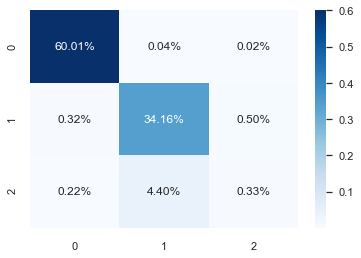

In [254]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

<AxesSubplot: >

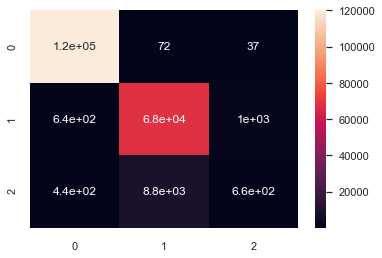

In [255]:
sns.heatmap(cf_matrix, annot=True)

In [256]:
dt = DecisionTreeClassifier(random_state=0)
dt,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(dt,X_train,y_train,X_test,y_test,model_name= 'DecisionTree')

In [257]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [258]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[119813    176    139]
 [   150  62846   6969]
 [   110   6185   3612]]


<AxesSubplot: >

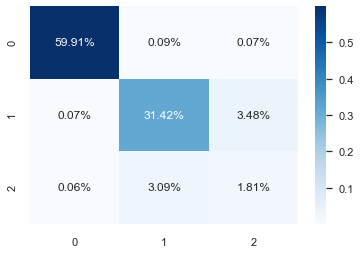

In [259]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [260]:
f1_score_macros

[0.6793649054477022, 0.7503227308881538]

In [261]:
rfc= RandomForestClassifier(n_estimators=40)
rfc,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(rfc,X_train,y_train,X_test,y_test,model_name= 'RandomForestClassifier')

In [262]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [263]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[120098     19     11]
 [   187  68314   1464]
 [   140   7850   1917]]


<AxesSubplot: >

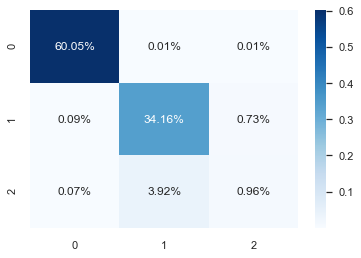

In [264]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [265]:
f1_score_macros

[0.6793649054477022, 0.7503227308881538, 0.7405562748979907]

knn_2= KNeighborsClassifier(n_neighbors=2)
knn_2,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(knn_2,X_train,y_train,X_test,y_test,model_name= 'knn_2')

model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [67]:
f1_score_macros

[0.21177524823445737,
 0.4597126122274506,
 0.4981181850693626,
 0.34981721343384486]

In [266]:
etc= ExtraTreesClassifier()
etc,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(etc,X_train,y_train,X_test,y_test,model_name= 'ETC')

In [267]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [268]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[120121      7      0]
 [   291  68929    745]
 [   237   8462   1208]]


<AxesSubplot: >

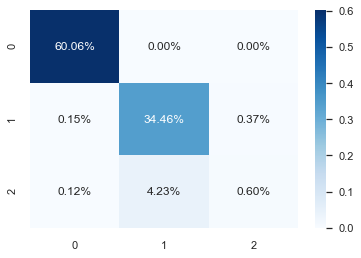

In [269]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [270]:
cv_10_accs

[-0.9447750000000001, -0.930485, -0.9510949999999999, -0.94995]

In [271]:
df_results_no_cluster = pd.DataFrame({'model_names':model_names,'cv_10_accs':[-1*i for i in cv_10_accs], 'f1_score_macros':f1_score_macros})

<AxesSubplot: xlabel='model_names', ylabel='cv_10_accs'>

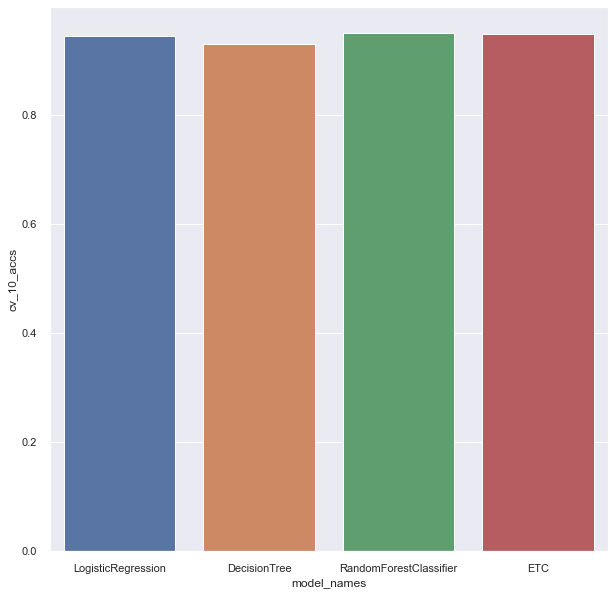

In [272]:
plt.figure(figsize=(10,10))
sns.barplot(data=df_results_no_cluster, x="model_names", y="cv_10_accs")

<AxesSubplot: xlabel='model_names', ylabel='f1_score_macros'>

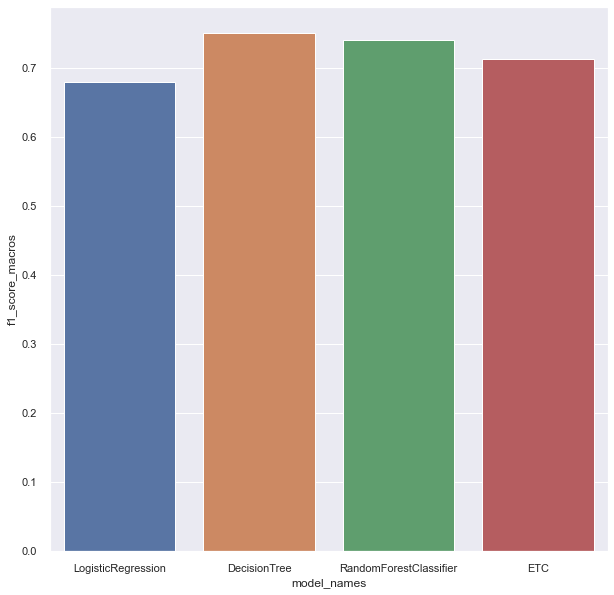

In [273]:
plt.figure(figsize=(10,10))
sns.barplot(data=df_results_no_cluster, x="model_names", y="f1_score_macros")

In [274]:
features=list(X_train.columns)

In [275]:
feature_importances=pd.DataFrame({'feature':features,'importance':rfc.feature_importances_})
feature_importances.head()

,feature,importance
0,GENDER,0.002651
1,OCPTN_RISK,0.003116
2,RES_CNTRY_CA,0.002835
3,CNTRY_OF_INCOME_CA,0.000442
4,PEP_FL,0.058392


In [276]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

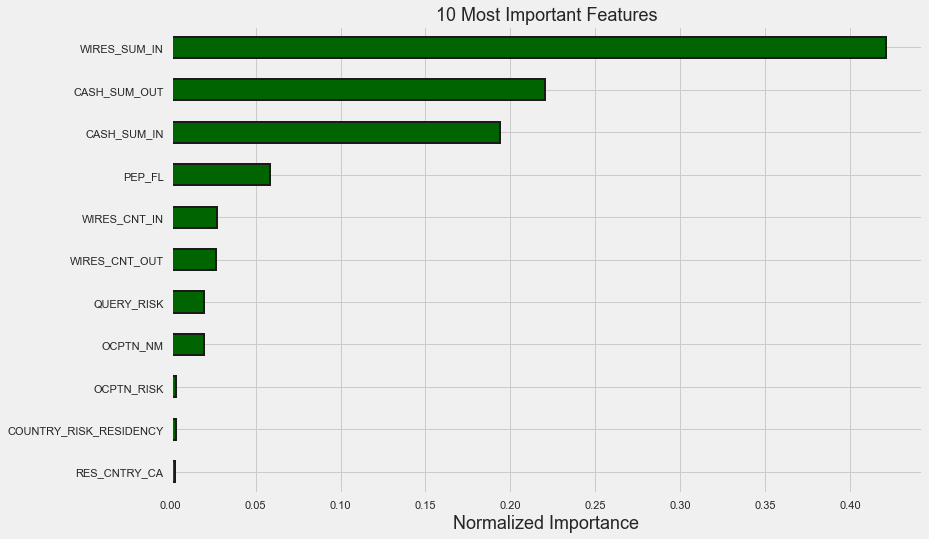

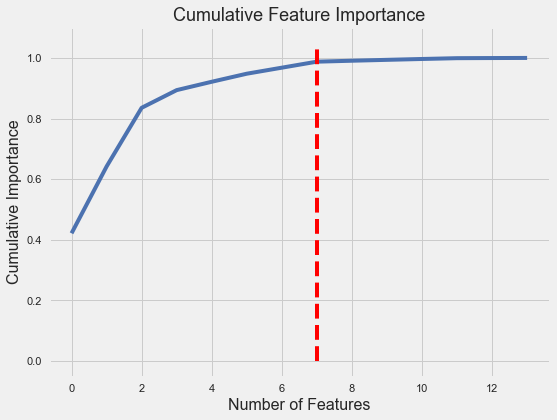

7 features required for 95% of cumulative importance.


In [277]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)


In [278]:
# So basically we can represent the model with just 7 features.

svm_c= svm.SVC()
svm_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(svm_c,X_train,y_train,X_test,y_test,model_name= 'SVM-classifier')

model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [245]:
# Now we include clusters in the dataset


#### Training various supervised moodels on dataset (including cluster)

In [17]:
df_c= pd.read_csv('./train_df_cluster_kmeans_6_v10_100factor_ls14.0.csv')
df_c= df_c.drop(['customer_add_date','customer_ids','customer_names','Unnamed: 0'],axis=1)
#df= df.drop([],axis=1)./train_df_cluster_kmeans_6_v10_100factor_ls14.0.csv

In [18]:
y= df_c.Risk
df_c = df_c.drop(['Risk'],axis=1)

In [19]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(df_c,y, test_size=0.20, random_state=42)

In [20]:
X_train_c

,GENDER,OCPTN_RISK,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,OCPTN_NM,QUERY_RISK,CASH_SUM_IN,CASH_SUM_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_CNT_OUT,clusters_k6
566853,0.0,0.0,1,1,0,0,0,0.995883,0.749783,0.646754,0.603895,0.662370,0.583384,0.585876,2
382311,1.0,0.0,1,1,0,0,0,0.483785,0.652486,0.688686,0.757643,0.684759,0.773516,0.775011,2
241519,1.0,0.0,1,1,0,0,0,0.977962,0.645351,0.692256,0.733413,0.698098,0.658590,0.704020,3
719220,1.0,2.0,1,1,0,0,0,0.926890,0.664801,0.769064,0.583466,0.798674,0.613688,0.573425,2
905718,1.0,2.0,1,1,0,0,0,0.749838,0.796337,0.683021,0.592046,0.631008,0.622609,0.343124,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0.0,0.0,1,1,0,0,0,0.977962,0.695779,0.663790,0.601113,0.507008,0.597583,0.471614,3
365838,1.0,0.0,1,1,0,0,0,0.483785,0.732791,0.688389,0.529645,0.571398,0.508531,0.454760,5
131932,1.0,2.0,1,1,0,0,0,0.668164,0.718800,0.813870,0.880837,0.878773,0.848787,0.775646,5
671155,0.0,2.0,1,1,0,0,0,0.926890,0.617483,0.666499,0.715477,0.586222,0.303722,0.547856,0


In [22]:
X_test_c.to_csv('15coltest_csv.csv')

In [23]:
y_test_c.to_csv('15coly_csv.csv')

In [283]:
c_model_names = []
c_cv_10_accs= []
c_classification_reports= []
c_accs =[]
c_f1_score_macros=[] 
c_p_scores =[]
c_r_scores = []

In [284]:
lm_c = LogisticRegression()
lm_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(lm_c,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'LogisticRegression')

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [285]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [286]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[120011     92     25]
 [   683  68448    834]
 [   508   8875    524]]


<AxesSubplot: >

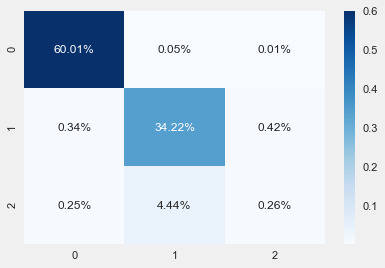

In [287]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

<AxesSubplot: >

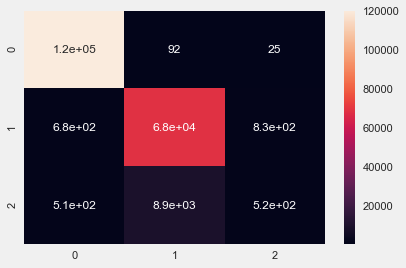

In [288]:
sns.heatmap(cf_matrix, annot=True)

In [289]:
c_f1_score_macros

[0.6720899018697356]

In [290]:
dt_c = DecisionTreeClassifier(random_state=0)
dt_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(dt_c,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'DecisionTree')

In [291]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [292]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[119795    194    139]
 [   160  62741   7064]
 [   119   6219   3569]]


<AxesSubplot: >

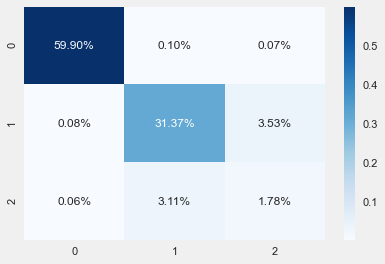

In [293]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [294]:
c_f1_score_macros

[0.6720899018697356, 0.7482030840662519]

In [295]:
f1_score_macros

[0.6793649054477022,
 0.7503227308881538,
 0.7405562748979907,
 0.7123291297983058]

In [296]:
rf_c= RandomForestClassifier(n_estimators=40)
rf_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(rfc,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'RandomForestClassifier')

In [297]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [298]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[120102     19      7]
 [   186  68418   1361]
 [   131   7909   1867]]


<AxesSubplot: >

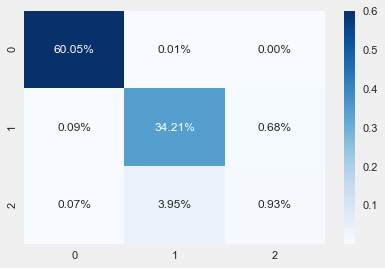

In [299]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [300]:
c_model_names

['LogisticRegression', 'DecisionTree', 'RandomForestClassifier']

knn_2_c= KNeighborsClassifier(n_neighbors=2)
knn_2_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(knn_2_c,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'knn_2')

c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [301]:
etc_c= ExtraTreesClassifier()
etc_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(etc_c,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'ExtraTreeClassifier')

In [302]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [303]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[120123      5      0]
 [   336  69003    626]
 [   252   8669    986]]


<AxesSubplot: >

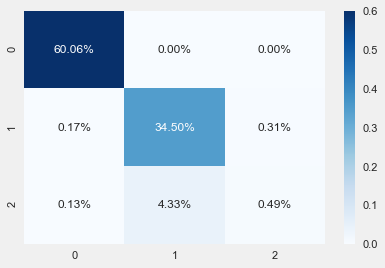

In [304]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [305]:
df_results_cluster = pd.DataFrame({'model_names':c_model_names,'cv_10_accs':[-1*i for i in c_cv_10_accs], 'f1_score_macros':c_f1_score_macros})

<AxesSubplot: xlabel='model_names', ylabel='cv_10_accs'>

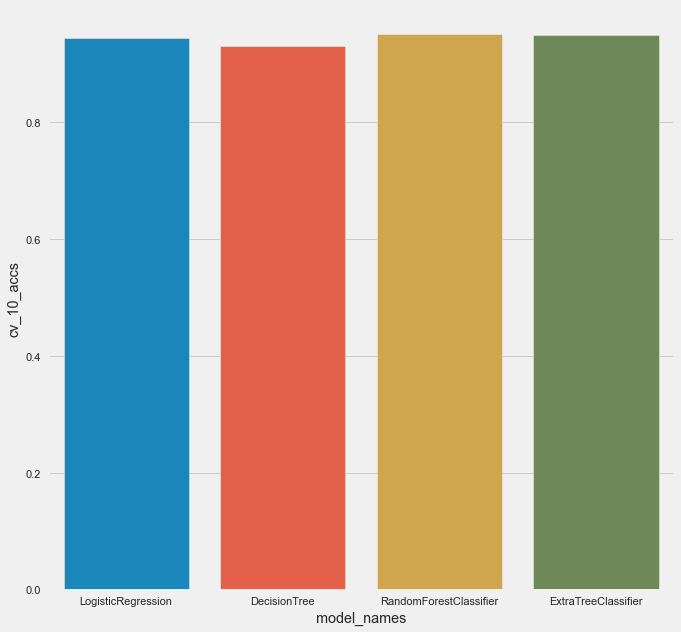

In [306]:
plt.figure(figsize=(10,10))
sns.barplot(data=df_results_cluster, x="model_names", y="cv_10_accs")

<AxesSubplot: xlabel='model_names', ylabel='f1_score_macros'>

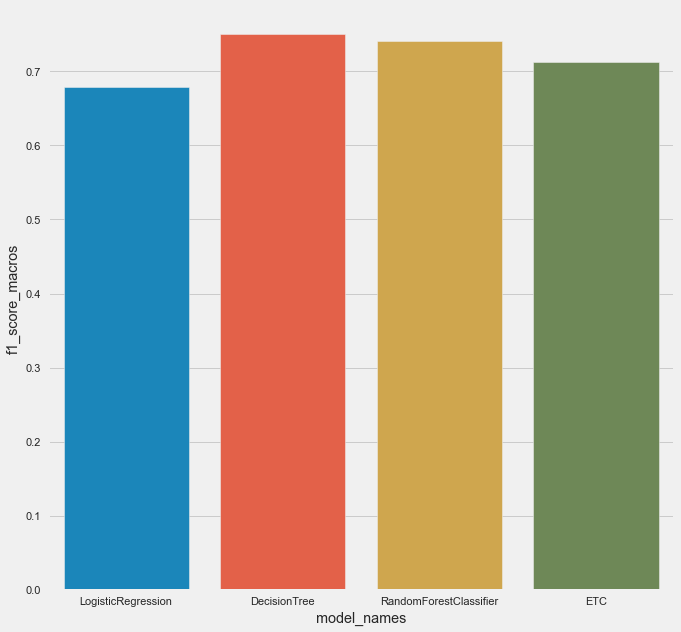

In [307]:
plt.figure(figsize=(10,10))
sns.barplot(data=df_results_no_cluster, x="model_names", y="f1_score_macros")

In [308]:
features=list(X_train_c.columns)

In [309]:
len(rf_c.feature_importances_)

15

In [310]:
len(rfc.feature_importances_)

15

In [311]:
feature_importances_cluster=pd.DataFrame({'feature':features,'importance':rf_c.feature_importances_})
feature_importances_cluster.head()

,feature,importance
0,GENDER,0.002670
1,OCPTN_RISK,0.003247
2,RES_CNTRY_CA,0.003593
3,CNTRY_OF_INCOME_CA,0.000440
4,PEP_FL,0.035960


In [312]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

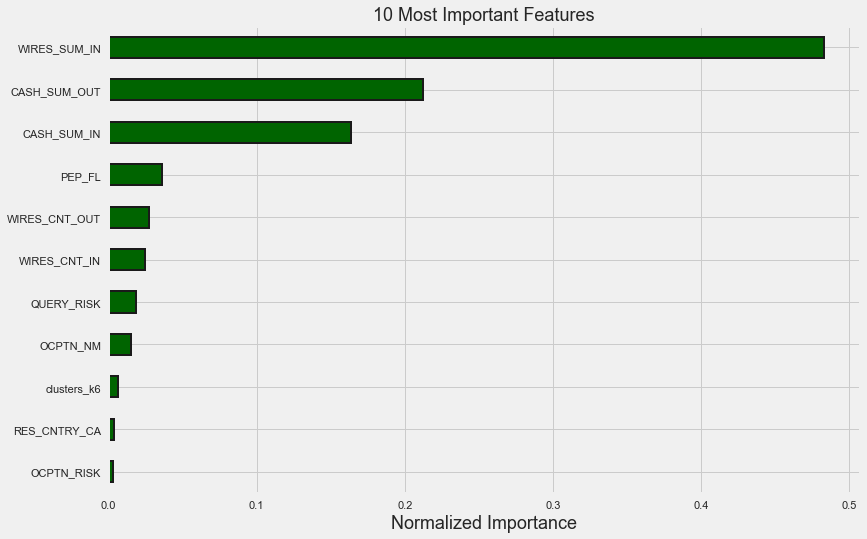

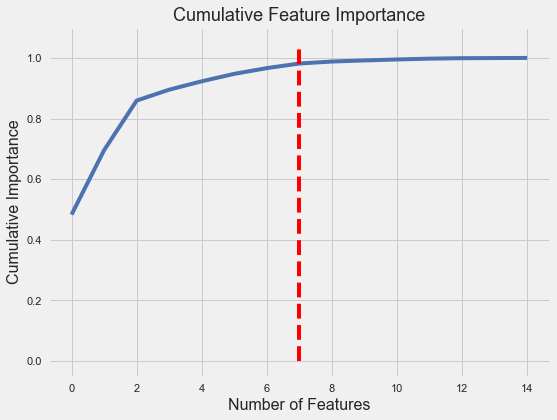

7 features required for 95% of cumulative importance.


In [313]:
norm_fi = plot_feature_importances(feature_importances_cluster, threshold=0.95)


In [314]:
# So basically we can represent the model with just 7 features.

In [315]:
df_results_no_cluster

,model_names,cv_10_accs,f1_score_macros
0,LogisticRegression,0.944775,0.679365
1,DecisionTree,0.930485,0.750323
2,RandomForestClassifier,0.951095,0.740556
3,ETC,0.949950,0.712329


In [316]:
df_results_cluster

,model_names,cv_10_accs,f1_score_macros
0,LogisticRegression,0.944700,0.672090
1,DecisionTree,0.930615,0.748203
2,RandomForestClassifier,0.951060,0.739314
3,ExtraTreeClassifier,0.949880,0.701156


In [320]:
X_train.columns

Index(['GENDER', 'OCPTN_RISK', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL',
       'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'OCPTN_NM',
       'QUERY_RISK', 'CASH_SUM_IN', 'CASH_SUM_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_CNT_OUT'],
      dtype='object')

In [325]:
y_train.value_counts()

0    479872
1    280035
2     40093
Name: Risk, dtype: int64

In [345]:
!pip uninstall dtreeviz

^C


In [364]:
list(X_test.columns)


['GENDER',
 'OCPTN_RISK',
 'RES_CNTRY_CA',
 'CNTRY_OF_INCOME_CA',
 'PEP_FL',
 'COUNTRY_RISK_INCOME',
 'COUNTRY_RISK_RESIDENCY',
 'OCPTN_NM',
 'QUERY_RISK',
 'CASH_SUM_IN',
 'CASH_SUM_OUT',
 'WIRES_SUM_IN',
 'WIRES_CNT_IN',
 'WIRES_CNT_OUT']

In [ ]:
precision: int = 2,
             orientation: ('TD', 'LR') = "TD",
             instance_orientation: ("TD", "LR") = "LR",
             show_root_edge_labels: bool = True,
             show_node_labels: bool = False,
             show_just_path: bool = False,
             fancy: bool = True,
             histtype: ('bar', 'barstacked', 'strip') = 'barstacked',
             leaftype: ('pie', 'barh') = 'pie',
             highlight_path: List[int] = [],
             x: np.ndarray = None,
             max_X_features_LR: int = 10,
             max_X_features_TD: int = 20,
             depth_range_to_display: tuple = None,
             label_fontsize: int = 12,
             ticks_fontsize: int = 8,
             fontname: str = "Arial",
             title: str = None,
             title_fontsize: int = 10,
             colors: dict = None,
             scale=1.0
             ) \

In [381]:
#y_test.values.tolist()

In [398]:
X_train.shape

(800000, 14)

In [424]:
from dtreeviz.trees import model # remember to load the package

viz =model(dt, X_test.values, y_test.values,
                target_name="Classes",
                feature_names=list(X_test.columns),
                class_names=[0,1,2])



In [419]:
X_test.to_csv('xtest.csv')

In [423]:
y_test.to_csv('ytest.csv')

In [421]:
import pickle
filename = 'dt_noCluster.sav'
pickle.dump(dt, open(filename, 'wb'))
 


In [422]:
filename = 'dt_Cluster.sav'
pickle.dump(dt_c, open(filename, 'wb'))

In [ ]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)